<a href="https://colab.research.google.com/github/Witcape/PSO/blob/main/Weights_Final_Iterations/ITERATION_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TEST

In [ ]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.7 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-zh72s4w3
  Entered build tracker: /tmp/pip-build-tracker-zh72s4w3
  Created temporary directory: /tmp/pip-install-ln3fqvc9
  Created temporary directory: /tmp/pip-ephem-wheel-cache-xgw71njy
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  Starting new HTTPS connection (1

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [ ]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt

In [ ]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

In [ ]:
# GPU
lcpp_llm = None
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

In [ ]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

In [ ]:
CostFunction = sphere  #
nVar = 10  # Number of Decision Variables
VarSize = (nVar,)  # Size of Decision Variables Matrix
VarMin = -10  # Lower Bound of Variables
VarMax = 10  # Upper Bound of Variables

In [ ]:
MaxIt = 20  # Maximum Number of Iterations
nPop = 20

In [ ]:
w = 1  # Inertia Weight
wdamp = 0.99  # Inertia Weight Damping Ratio
c1 = 1.5  # Personal Learning Coefficient
c2 = 2.0  # Global Learning Coefficient

In [ ]:
VelMax = 0.1 * (VarMax - VarMin)
VelMin = -VelMax

In [ ]:
particles = []

for _ in range(nPop):
    position = np.random.uniform(VarMin, VarMax, VarSize)
    velocity = np.zeros(VarSize)
    cost = CostFunction(position)
    best_position = position.copy()
    best_cost = cost
    particles.append({
        'Position': position,
        'Velocity': velocity,
        'Cost': cost,
        'Best': {
            'Position': best_position,
            'Cost': best_cost
        }
    })
print(np.size(particles))

In [ ]:
GlobalBest = {'Position': None, 'Cost': np.inf}

for p in particles:
    if p['Cost'] < GlobalBest['Cost']:
        GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

BestCost = np.zeros(MaxIt)

In [ ]:
w_values = []
g_values = []

for it in range(MaxIt):
    for p in particles:
        # Update Velocity
        r1 = np.random.rand(*VarSize)
        r2 = np.random.rand(*VarSize)
        p['Velocity'] = (
            w * p['Velocity']
            + c1 * r1 * (p['Best']['Position'] - p['Position'])
            + c2 * r2 * (GlobalBest['Position'] - p['Position'])
        )

        # Apply Velocity Limits
        p['Velocity'] = np.maximum(p['Velocity'], VelMin)
        p['Velocity'] = np.minimum(p['Velocity'], VelMax)

        # Update Position
        p['Position'] += p['Velocity']

        # Velocity Mirror Effect
        IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
        p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

        # Apply Position Limits
        p['Position'] = np.maximum(p['Position'], VarMin)
        p['Position'] = np.minimum(p['Position'], VarMax)

        # Evaluation
        p['Cost'] = CostFunction(p['Position'])

        # Update Personal Best
        if p['Cost'] < p['Best']['Cost']:
            p['Best']['Position'] = p['Position'].copy()
            p['Best']['Cost'] = p['Cost']

            # Update Global Best
            if p['Best']['Cost'] < GlobalBest['Cost']:  # tell best cost using roullete wheel. LLM will check for global best
                GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']} # tell best cost using roullete wheel

    BestCost[it] = GlobalBest['Cost']

    print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

    prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
    w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

    USER: {prompt}

    ASSISTANT:
    '''

    w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                          repeat_penalty=1.2, top_k=150,
                          echo=True)

    g_values.append(GlobalBest['Cost'])
    BestCost[it] = GlobalBest['Cost']

    text_response = w_response['choices'][0]['text']
    value = re.findall(r'-?\d+\.\d+', text_response)
    value = [float(num) for num in value]

    value = value[np.size(value) - 1]
    print(f'w{it+1} = {value}')
    w_values.append(w)
    w = value

w_values.append(w)
print(w_values)

# Function

In [1]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.6 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-0jhh03jm
  Entered build tracker: /tmp/pip-build-tracker-0jhh03jm
  Created temporary directory: /tmp/pip-install-dkav40q7
  Created temporary directory: /tmp/pip-ephem-wheel-cache-abr0f28z
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  No cache entry available
  Start

In [2]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [3]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt
import time

In [4]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

llama-2-13b-chat.ggmlv3.q5_1.bin:   0%|          | 0.00/9.76G [00:00<?, ?B/s]

In [5]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


In [6]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 955.4 kB/s eta 0:00:00


In [7]:
import numpy as np
import re

def run_pso(
    CostFunction, nVar=10, VarMin=-10, VarMax=10, MaxIt=20, nPop=500,
    w=1, wdamp=0.99, c1=2.05, c2=2.05, n_threads=2, n_batch=512, n_gpu_layers=32, chi=0.729843788
):
    VarSize = (nVar,)
    VelMax = 0.1 * (VarMax - VarMin)
    VelMin = -VelMax

    particles = []

    for _ in range(nPop):
        position = np.random.uniform(VarMin, VarMax, VarSize)
        velocity = np.zeros(VarSize)
        cost = CostFunction(position)
        best_position = position.copy()
        best_cost = cost
        particles.append({
            'Position': position,
            'Velocity': velocity,
            'Cost': cost,
            'Best': {
                'Position': best_position,
                'Cost': best_cost
            }
        })

    GlobalBest = {'Position': None, 'Cost': np.inf}

    for p in particles:
        if p['Cost'] < GlobalBest['Cost']:
            GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

    BestCost = np.zeros(MaxIt)
    w_values = []
    g_values = []

    for it in range(MaxIt):
        for p in particles:
            r1 = np.random.rand(*VarSize)
            r2 = np.random.rand(*VarSize)
            p['Velocity'] = chi * (
                p['Velocity']
                + c1 * r1 * (p['Best']['Position'] - p['Position'])
                + c2 * r2 * (GlobalBest['Position'] - p['Position'])
            )

            # Apply Velocity Limits
            p['Velocity'] = np.maximum(p['Velocity'], VelMin)
            p['Velocity'] = np.minimum(p['Velocity'], VelMax)

            # Update Position
            p['Position'] += p['Velocity']

            # Velocity Mirror Effect
            IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
            p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

            # Apply Position Limits
            p['Position'] = np.maximum(p['Position'], VarMin)
            p['Position'] = np.minimum(p['Position'], VarMax)

            # Evaluation
            p['Cost'] = CostFunction(p['Position'])

            # Update Personal Best
            if p['Cost'] < p['Best']['Cost']:
                p['Best']['Position'] = p['Position'].copy()
                p['Best']['Cost'] = p['Cost']

                # Update Global Best
                if p['Best']['Cost'] < GlobalBest['Cost']:
                    GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}


        BestCost[it] = GlobalBest['Cost']
        print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

        if(it <= 20):
          prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
          w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

          USER: {prompt}

          ASSISTANT:
          '''

          w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                                repeat_penalty=1.2, top_k=150, echo=True)

          text_response = w_response['choices'][0]['text']
          value = re.findall(r'-?\d+\.\d+', text_response)
          value = [float(num) for num in value]

          if value:
              w = value[-1]
              print(f"w{it+1} = {w}")
          else:
              print("Warning: LLM failed to provide a valid weight. Retaining previous weight.")

          w_values.append(w)
          g_values.append(GlobalBest['Cost'])

        else:
          w *= wdamp

          w_values.append(w)
          g_values.append(GlobalBest['Cost'])

    w_values.append(w)
    print("Final Weights:", w_values)
    return BestCost, w_values, g_values

In [8]:
# def sphere(x):
#     return sum(x**2)

In [9]:
# BestCost, w_values, g_values = run_pso(CostFunction=sphere)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

# GNBG class definition
class GNBG:
    def __init__(self, MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition):
        self.MaxEvals = MaxEvals
        self.AcceptanceThreshold = AcceptanceThreshold
        self.Dimension = Dimension
        self.CompNum = CompNum
        self.MinCoordinate = MinCoordinate
        self.MaxCoordinate = MaxCoordinate
        self.CompMinPos = CompMinPos
        self.CompSigma = CompSigma
        self.CompH = CompH
        self.Mu = Mu
        self.Omega = Omega
        self.Lambda = Lambda
        self.RotationMatrix = RotationMatrix
        self.OptimumValue = OptimumValue
        self.OptimumPosition = OptimumPosition
        self.FEhistory = []
        self.FE = 0
        self.BestFoundPosition = None
        self.AcceptanceReachPoint = np.inf
        self.BestFoundResult = np.inf


    def fitness(self, X):
        if len(X.shape)<2:
            X = X.reshape(1,-1)
        SolutionNumber = X.shape[0]
        result = np.nan * np.ones(SolutionNumber)
        for jj in range(SolutionNumber):
            x = X[jj, :].reshape(-1, 1)  # Ensure column vector
            f = np.nan * np.ones(self.CompNum)
            for k in range(self.CompNum):
                if len(self.RotationMatrix.shape) == 3:
                    rotation_matrix = self.RotationMatrix[:, :, k]
                else:
                    rotation_matrix = self.RotationMatrix

                a = self.transform((x - self.CompMinPos[k, :].reshape(-1, 1)).T @ rotation_matrix.T, self.Mu[k, :], self.Omega[k, :])
                b = self.transform(rotation_matrix @ (x - self.CompMinPos[k, :].reshape(-1, 1)), self.Mu[k, :], self.Omega[k, :])
                f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]

            result[jj] = np.min(f)
            if self.FE > (self.MaxEvals-1):
                return result
            self.FE += 1
            self.FEhistory = np.append(self.FEhistory, result[jj])
            if self.BestFoundResult > result[jj]:
                self.BestFoundResult = result[jj]
            if abs(self.FEhistory[self.FE-1] - self.OptimumValue) < self.AcceptanceThreshold and np.isinf(self.AcceptanceReachPoint):
                self.AcceptanceReachPoint = self.FE
        return result
    def transform(self, X, Alpha, Beta):
        Y = X.copy()
        tmp = (X > 0)
        Y[tmp] = np.log(X[tmp])
        Y[tmp] = np.exp(Y[tmp] + Alpha[0] * (np.sin(Beta[0] * Y[tmp]) + np.sin(Beta[1] * Y[tmp])))
        tmp = (X < 0)
        Y[tmp] = np.log(-X[tmp])
        Y[tmp] = -np.exp(Y[tmp] + Alpha[1] * (np.sin(Beta[2] * Y[tmp]) + np.sin(Beta[3] * Y[tmp])))
        return Y

In [11]:
# ProblemIndex = 22  # Choose a problem instance from 1 to 24
# folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat

# # Load GNBG data for the selected problem instance
# if 1 <= ProblemIndex <= 24:
#     filename = f'f{ProblemIndex}.mat'
#     GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']
#     MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
#     AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
#     Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
#     CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
#     MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
#     MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
#     CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
#     CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
#     CompH = np.array(GNBG_tmp['Component_H'][0, 0])
#     Mu = np.array(GNBG_tmp['Mu'][0, 0])
#     Omega = np.array(GNBG_tmp['Omega'][0, 0])
#     Lambda = np.array(GNBG_tmp['lambda'][0, 0])
#     RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
#     OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
#     OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])
# else:
#     raise ValueError('ProblemIndex must be between 1 and 24.')

# # Initialize GNBG problem instance
# gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)
# popsize = 500000
# print(MaxEvals // popsize)

In [12]:
# nVar = Dimension
# VarMin = MinCoordinate
# VarMax = MaxCoordinate
# popsize = 500000
# nPop = 100
# maxiter = MaxEvals // popsize

# BestCost, w_values, g_values, milestone_results = run_pso(
#     CostFunction=gnbg.fitness,
#     nVar=nVar,
#     VarMin=VarMin,
#     VarMax=VarMax,
#     MaxIt=maxiter,
#     nPop=nPop
# )

In [13]:
# milestone_means = {}
# milestone_stds = {}

# for milestone, costs in milestone_results.items():
#     if costs:  # Check if there are any results for this milestone
#         mean_cost = np.mean(costs)
#         std_cost = np.std(costs)
#         milestone_means[milestone] = mean_cost
#         milestone_stds[milestone] = std_cost
#         print(f"At {milestone} function evaluations - Mean Cost: {mean_cost}, Std Dev: {std_cost}")

# # Plot milestone results: Mean cost with standard deviation error bars
# milestones_sorted = sorted(milestone_means.keys())
# means = [milestone_means[m] for m in milestones_sorted]
# stds = [milestone_stds[m] for m in milestones_sorted]

# plt.errorbar(milestones_sorted, means, yerr=stds, fmt='o', color='b', capsize=5)
# plt.xlabel('Function Evaluations')
# plt.ylabel('Cost')
# plt.title('Cost vs Function Evaluations with Std Dev')
# plt.show()

In [14]:
# plt.plot(w_values)
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations')
# plt.show()

In [15]:
# plt.plot(g_values)
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations')
# plt.show()

In [16]:
# # Print best cost and best position
# print("Best Cost Found by PSO:\n\n", BestCost)

# # Print the position corresponding to the best cost
# print("\n\nBest Position:", g_values[-1])

# RUN ALL ALGOS

In [17]:
costs = []
errors = []

In [18]:
def run_all_problems(folder_path, num_problems=24):
    all_results = {}

    for problem_index in range(1, num_problems + 1):
        start_time = time.time()

        filename = f'f{problem_index}.mat'
        GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']

        MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
        AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
        Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
        CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
        MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
        MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
        CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
        CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
        CompH = np.array(GNBG_tmp['Component_H'][0, 0])
        Mu = np.array(GNBG_tmp['Mu'][0, 0])
        Omega = np.array(GNBG_tmp['Omega'][0, 0])
        Lambda = np.array(GNBG_tmp['lambda'][0, 0])
        RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
        OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
        OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])


        # Initialize GNBG problem instance
        gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)

        # Run PSO for the current problem
        nVar = Dimension
        VarMin = MinCoordinate
        VarMax = MaxCoordinate
        # MaxEvals = 500000
        nPop = 100
        # maxiter = MaxEvals // nPop
        maxiter = 500

        BestCost, w_values, g_values = run_pso(
            CostFunction=gnbg.fitness,
            nVar=nVar,
            VarMin=VarMin,
            VarMax=VarMax,
            MaxIt=maxiter,
            nPop=nPop
        )

        error = abs(BestCost[-1] - gnbg.OptimumValue)

        # Add error to results dictionary
        all_results[problem_index] = {
            'BestCost': BestCost,
            'BestPosition': g_values[-1],
            'w_values': w_values,
            'g_values': g_values,
            'OptimumValue': gnbg.OptimumValue,
            'Error': error
        }
        end_time = time.time()
        iteration_time = end_time - start_time

        print(f"Problem {problem_index} Best Cost:", BestCost)
        print(f"Problem {problem_index} Error:", error)
        print(f"Problem {problem_index} Time Taken: {iteration_time:.4f} seconds")


    return all_results

In [19]:
# Run for all 24 problems
folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat
results = run_all_problems(folder_path)

for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]
    print(problem_results['BestPosition'])
    costs.append(problem_results['BestPosition'])

# # Example of how to access results for a particular problem
# problem_1_results = results[1]
# print("\n\n\nProblem 1 Best Cost:", problem_1_results['BestCost'])
# print("Problem 1 Best Position:", problem_1_results['BestPosition'])
# print("Problem 1 Error:", problem_1_results['Error'])

# # Plotting results for one of the problems (e.g., Problem 1)
# plt.plot(problem_1_results['w_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations - Problem 1')
# plt.show()

# plt.plot(problem_1_results['g_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations - Problem 1')
# plt.show()


<ipython-input-10-920e6cc4fb83>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]
<ipython-input-7-2d427eabae00>:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BestCost[it] = GlobalBest['Cost']


Iteration 1: Best Cost = 63874.28366691505
w1 = 0.23456789
Iteration 2: Best Cost = 47676.00576353895


Llama.generate: prefix-match hit


w2 = 0.22987654
Iteration 3: Best Cost = 43235.30053674376


Llama.generate: prefix-match hit


w3 = 0.21345678
Iteration 4: Best Cost = 35856.401081489515


Llama.generate: prefix-match hit


w4 = 0.19523456
Iteration 5: Best Cost = 27351.68530792607


Llama.generate: prefix-match hit


w5 = 0.17823456
Iteration 6: Best Cost = 19052.65930258468


Llama.generate: prefix-match hit


w6 = 0.16982789
Iteration 7: Best Cost = 12744.199317153361


Llama.generate: prefix-match hit


w7 = 0.15432789
Iteration 8: Best Cost = 9818.637691533595


Llama.generate: prefix-match hit


w8 = 0.1456789
Iteration 9: Best Cost = 8422.842575249264


Llama.generate: prefix-match hit


w9 = 0.132456789
Iteration 10: Best Cost = 7321.013069827705


Llama.generate: prefix-match hit


w10 = 0.125
Iteration 11: Best Cost = 5391.951864428574


Llama.generate: prefix-match hit


w11 = 0.117
Iteration 12: Best Cost = 4909.505206416578


Llama.generate: prefix-match hit


w12 = 0.109
Iteration 13: Best Cost = 2667.86679779273


Llama.generate: prefix-match hit


w13 = 0.087
Iteration 14: Best Cost = 1047.9928041825062


Llama.generate: prefix-match hit


w14 = 0.092
Iteration 15: Best Cost = 1047.9928041825062


Llama.generate: prefix-match hit


w15 = 0.085
Iteration 16: Best Cost = 755.0601676136982


Llama.generate: prefix-match hit


w16 = 0.079
Iteration 17: Best Cost = 636.7336308872318


Llama.generate: prefix-match hit


w17 = 0.084
Iteration 18: Best Cost = -70.13907563581915


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = -70.13907563581915


Llama.generate: prefix-match hit


w19 = 0.065
Iteration 20: Best Cost = -82.19062798560492


Llama.generate: prefix-match hit


w20 = 0.073
Iteration 21: Best Cost = -82.19062798560492


Llama.generate: prefix-match hit


w21 = 0.065
Iteration 22: Best Cost = -82.19062798560492
Iteration 23: Best Cost = -233.76678481526176
Iteration 24: Best Cost = -478.221522849787
Iteration 25: Best Cost = -478.221522849787
Iteration 26: Best Cost = -567.5061442666089
Iteration 27: Best Cost = -585.2461721713737
Iteration 28: Best Cost = -591.4740268349702
Iteration 29: Best Cost = -606.9857206830875
Iteration 30: Best Cost = -691.2231447084733
Iteration 31: Best Cost = -691.2231447084733
Iteration 32: Best Cost = -702.6385923093146
Iteration 33: Best Cost = -743.3692802991104
Iteration 34: Best Cost = -779.6338798173006
Iteration 35: Best Cost = -791.603737968217
Iteration 36: Best Cost = -791.8866978177691
Iteration 37: Best Cost = -791.8866978177691
Iteration 38: Best Cost = -791.8866978177691
Iteration 39: Best Cost = -791.8866978177691
Iteration 40: Best Cost = -803.2228172968362
Iteration 41: Best Cost = -803.2228172968362
Iteration 42: Best Cost = -831.4473874899629
Iteration 43: Best Cost = -842.5255091009736


Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = -701.4059767797157


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = -701.4202295796857


Llama.generate: prefix-match hit


w3 = 0.29
Iteration 4: Best Cost = -701.4427857957049


Llama.generate: prefix-match hit


w4 = 0.23
Iteration 5: Best Cost = -701.4618600585989


Llama.generate: prefix-match hit


w5 = 0.19
Iteration 6: Best Cost = -701.4963756625258


Llama.generate: prefix-match hit


w6 = 0.175
Iteration 7: Best Cost = -701.5445577271776


Llama.generate: prefix-match hit


w7 = 0.148
Iteration 8: Best Cost = -701.5700579584479


Llama.generate: prefix-match hit


w8 = 0.135
Iteration 9: Best Cost = -701.5740084195045


Llama.generate: prefix-match hit


w9 = 0.127
Iteration 10: Best Cost = -701.581486161157


Llama.generate: prefix-match hit


w10 = 0.119
Iteration 11: Best Cost = -701.603319908722


Llama.generate: prefix-match hit


w11 = 0.105
Iteration 12: Best Cost = -701.6253181274791


Llama.generate: prefix-match hit


w12 = 0.097
Iteration 13: Best Cost = -701.6253181274791


Llama.generate: prefix-match hit


w13 = 0.085
Iteration 14: Best Cost = -701.6285013373644


Llama.generate: prefix-match hit


w14 = 0.092
Iteration 15: Best Cost = -701.6450109120865


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = -701.6748362361834


Llama.generate: prefix-match hit


w16 = 0.094
Iteration 17: Best Cost = -701.6748362361834


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = -701.6748362361834


Llama.generate: prefix-match hit


w18 = 0.094
Iteration 19: Best Cost = -701.6758724500099


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = -701.6914943790091


Llama.generate: prefix-match hit


w20 = 0.094
Iteration 21: Best Cost = -701.7040683563857


Llama.generate: prefix-match hit


w21 = 0.087
Iteration 22: Best Cost = -701.7086607260181
Iteration 23: Best Cost = -701.7112924140798
Iteration 24: Best Cost = -701.7483068058186
Iteration 25: Best Cost = -701.7543817474378
Iteration 26: Best Cost = -701.7543817474378
Iteration 27: Best Cost = -701.7543817474378
Iteration 28: Best Cost = -701.7696212449066
Iteration 29: Best Cost = -701.7696212449066
Iteration 30: Best Cost = -701.774581110599
Iteration 31: Best Cost = -701.775902357843
Iteration 32: Best Cost = -701.775902357843
Iteration 33: Best Cost = -701.7828187613602
Iteration 34: Best Cost = -701.7828187613602
Iteration 35: Best Cost = -701.7956112549041
Iteration 36: Best Cost = -701.8038836741589
Iteration 37: Best Cost = -701.8101010668262
Iteration 38: Best Cost = -701.8112188599878
Iteration 39: Best Cost = -701.8204698346548
Iteration 40: Best Cost = -701.8204698346548
Iteration 41: Best Cost = -701.8213981744325
Iteration 42: Best Cost = -701.8213981744325
Iteration 43: Best Cost = -701.8213981744325
I

Llama.generate: prefix-match hit


w1 = 0.32768
Iteration 2: Best Cost = 27552797714.335155


Llama.generate: prefix-match hit


w2 = 0.29456
Iteration 3: Best Cost = 23588730794.156803


Llama.generate: prefix-match hit


w3 = 0.23789
Iteration 4: Best Cost = 21023169127.55469


Llama.generate: prefix-match hit


w4 = 0.22456
Iteration 5: Best Cost = 15496501675.658712


Llama.generate: prefix-match hit


w5 = 0.19837
Iteration 6: Best Cost = 10408638493.222385


Llama.generate: prefix-match hit


w6 = 0.16524
Iteration 7: Best Cost = 6887539991.224587


Llama.generate: prefix-match hit


w7 = 0.15739
Iteration 8: Best Cost = 6876538327.213445


Llama.generate: prefix-match hit


w8 = 0.14286
Iteration 9: Best Cost = 5767346631.879165


Llama.generate: prefix-match hit


w9 = 0.13579
Iteration 10: Best Cost = 4953431540.768008


Llama.generate: prefix-match hit


w10 = 0.12468
Iteration 11: Best Cost = 4953431540.768008


Llama.generate: prefix-match hit


w11 = 0.11795
Iteration 12: Best Cost = 4463310263.258381


Llama.generate: prefix-match hit


w12 = 0.10832
Iteration 13: Best Cost = 3282633196.0959883


Llama.generate: prefix-match hit


w13 = 0.097654
Iteration 14: Best Cost = 2030250951.8927526


Llama.generate: prefix-match hit


w14 = 0.082371
Iteration 15: Best Cost = 1934655090.2851138


Llama.generate: prefix-match hit


w15 = 0.095645
Iteration 16: Best Cost = 1787669700.783315


Llama.generate: prefix-match hit


w16 = 0.087321
Iteration 17: Best Cost = 1592101464.1123545


Llama.generate: prefix-match hit


w17 = 0.094567
Iteration 18: Best Cost = 1456411971.3279552


Llama.generate: prefix-match hit


w18 = 0.083254
Iteration 19: Best Cost = 1456411971.3279552


Llama.generate: prefix-match hit


w19 = 0.076953
Iteration 20: Best Cost = 1218921904.6033068


Llama.generate: prefix-match hit


w20 = 0.068427
Iteration 21: Best Cost = 1148558306.789435


Llama.generate: prefix-match hit


w21 = 0.059321
Iteration 22: Best Cost = 1148558306.789435
Iteration 23: Best Cost = 1148558306.789435
Iteration 24: Best Cost = 1054875522.2037793
Iteration 25: Best Cost = 874866911.3119328
Iteration 26: Best Cost = 808940692.4961203
Iteration 27: Best Cost = 808940692.4961203
Iteration 28: Best Cost = 698580921.1198611
Iteration 29: Best Cost = 698580921.1198611
Iteration 30: Best Cost = 682825312.20651
Iteration 31: Best Cost = 608626466.4482442
Iteration 32: Best Cost = 608626466.4482442
Iteration 33: Best Cost = 530891471.4109782
Iteration 34: Best Cost = 530891471.4109782
Iteration 35: Best Cost = 494792037.06682515
Iteration 36: Best Cost = 420676520.11060333
Iteration 37: Best Cost = 237039869.40783188
Iteration 38: Best Cost = 237039869.40783188
Iteration 39: Best Cost = 216574872.73703694
Iteration 40: Best Cost = 216574872.73703694
Iteration 41: Best Cost = 216574872.73703694
Iteration 42: Best Cost = 178241775.28692064
Iteration 43: Best Cost = 178241775.28692064
Iteration

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 215011.49359653582


Llama.generate: prefix-match hit


w2 = 0.2956789
Iteration 3: Best Cost = 181617.1682257066


Llama.generate: prefix-match hit


w3 = 0.2345678
Iteration 4: Best Cost = 136035.6225112869


Llama.generate: prefix-match hit


w4 = 0.2298478
Iteration 5: Best Cost = 121491.40920312902


Llama.generate: prefix-match hit


w5 = 0.2256394
Iteration 6: Best Cost = 96910.10569294439


Llama.generate: prefix-match hit


w6 = 0.2087625
Iteration 7: Best Cost = 79565.88545809846


Llama.generate: prefix-match hit


w7 = 0.194375
Iteration 8: Best Cost = 70169.94252819981


Llama.generate: prefix-match hit


w8 = 0.182625
Iteration 9: Best Cost = 51375.85599988571


Llama.generate: prefix-match hit


w9 = 0.174324
Iteration 10: Best Cost = 42084.56935408494


Llama.generate: prefix-match hit


w10 = 0.168597
Iteration 11: Best Cost = 28839.122558594212


Llama.generate: prefix-match hit


w11 = 0.143244
Iteration 12: Best Cost = 26894.755291599886


Llama.generate: prefix-match hit


w12 = 0.125
Iteration 13: Best Cost = 17784.655949102278


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 15437.518508116706


Llama.generate: prefix-match hit


w14 = 0.109
Iteration 15: Best Cost = 15437.518508116706


Llama.generate: prefix-match hit


w15 = 0.107
Iteration 16: Best Cost = 14035.496450624312


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 12036.809586531996


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 10824.493877555251


Llama.generate: prefix-match hit


w18 = 0.095
Iteration 19: Best Cost = 9181.935604521605


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = 8398.471326496332


Llama.generate: prefix-match hit


w20 = 0.092
Iteration 21: Best Cost = 8215.90524691977


Llama.generate: prefix-match hit


w21 = 0.085
Iteration 22: Best Cost = 7188.541029457836
Iteration 23: Best Cost = 5040.339998460148
Iteration 24: Best Cost = 3586.6131315247662
Iteration 25: Best Cost = 3506.493069022883
Iteration 26: Best Cost = 3506.493069022883
Iteration 27: Best Cost = 3169.8758909737276
Iteration 28: Best Cost = 2753.9381128662903
Iteration 29: Best Cost = 2602.001143980686
Iteration 30: Best Cost = 1690.533276455505
Iteration 31: Best Cost = 1690.533276455505
Iteration 32: Best Cost = 1690.533276455505
Iteration 33: Best Cost = 1690.533276455505
Iteration 34: Best Cost = 1343.6269472436275
Iteration 35: Best Cost = 1343.6269472436275
Iteration 36: Best Cost = 1343.6269472436275
Iteration 37: Best Cost = 1140.6347924449929
Iteration 38: Best Cost = 1133.1538948183133
Iteration 39: Best Cost = 1133.1538948183133
Iteration 40: Best Cost = 1116.1508070857149
Iteration 41: Best Cost = 949.6584895373461
Iteration 42: Best Cost = 949.6584895373461
Iteration 43: Best Cost = 911.2555148452828
Iteration 

Llama.generate: prefix-match hit


w1 = 0.2745398613543986
Iteration 2: Best Cost = -334.26386325639254


Llama.generate: prefix-match hit


w2 = 0.2685789473685789
Iteration 3: Best Cost = -334.29857877072016


Llama.generate: prefix-match hit


w3 = 0.25
Iteration 4: Best Cost = -334.34860231438137


Llama.generate: prefix-match hit


w4 = 0.2384796592449726
Iteration 5: Best Cost = -334.4304269227639


Llama.generate: prefix-match hit


w5 = 0.224638592138981
Iteration 6: Best Cost = -334.4696675448462


Llama.generate: prefix-match hit


w6 = 0.207125
Iteration 7: Best Cost = -334.4946804939902


Llama.generate: prefix-match hit


w7 = 0.184375
Iteration 8: Best Cost = -334.50528410178856


Llama.generate: prefix-match hit


w8 = 0.1625
Iteration 9: Best Cost = -334.50528410178856


Llama.generate: prefix-match hit


w9 = 0.14375
Iteration 10: Best Cost = -334.62364762096917


Llama.generate: prefix-match hit


w10 = 0.12896
Iteration 11: Best Cost = -334.62364762096917


Llama.generate: prefix-match hit


w11 = 0.12345
Iteration 12: Best Cost = -334.62364762096917


Llama.generate: prefix-match hit


w12 = 0.1176
Iteration 13: Best Cost = -334.6459624958947


Llama.generate: prefix-match hit


w13 = 0.1085
Iteration 14: Best Cost = -334.6711821171705


Llama.generate: prefix-match hit


w14 = 0.1043
Iteration 15: Best Cost = -334.6776926823244


Llama.generate: prefix-match hit


w15 = 0.0976
Iteration 16: Best Cost = -334.6800054152853


Llama.generate: prefix-match hit


w16 = 0.0854
Iteration 17: Best Cost = -334.71954718407005


Llama.generate: prefix-match hit


w17 = 0.0762
Iteration 18: Best Cost = -334.73060033325027


Llama.generate: prefix-match hit


w18 = 0.0598
Iteration 19: Best Cost = -334.7654396022835


Llama.generate: prefix-match hit


w19 = 0.0762
Iteration 20: Best Cost = -334.7654396022835


Llama.generate: prefix-match hit


w20 = 0.0578
Iteration 21: Best Cost = -334.7908048397837


Llama.generate: prefix-match hit


w21 = 0.0432
Iteration 22: Best Cost = -334.82573095027055
Iteration 23: Best Cost = -334.82573095027055
Iteration 24: Best Cost = -334.82573095027055
Iteration 25: Best Cost = -334.82573095027055
Iteration 26: Best Cost = -334.82573095027055
Iteration 27: Best Cost = -334.82573095027055
Iteration 28: Best Cost = -334.8564202133176
Iteration 29: Best Cost = -334.8714520213311
Iteration 30: Best Cost = -334.8714520213311
Iteration 31: Best Cost = -334.88030909254064
Iteration 32: Best Cost = -334.88030909254064
Iteration 33: Best Cost = -334.9149387916731
Iteration 34: Best Cost = -334.91828628414027
Iteration 35: Best Cost = -334.9300359843555
Iteration 36: Best Cost = -334.9300359843555
Iteration 37: Best Cost = -334.9324156900882
Iteration 38: Best Cost = -334.96018495458134
Iteration 39: Best Cost = -334.96018495458134
Iteration 40: Best Cost = -334.96018495458134
Iteration 41: Best Cost = -334.9770071952626
Iteration 42: Best Cost = -334.99002210781896
Iteration 43: Best Cost = -33

Llama.generate: prefix-match hit


w1 = 0.45
Iteration 2: Best Cost = -183.58880949228364


Llama.generate: prefix-match hit


w2 = 0.2983567115053945
Iteration 3: Best Cost = -183.62590110398887


Llama.generate: prefix-match hit


w3 = 0.2751971836427726
Iteration 4: Best Cost = -183.6518228890612


Llama.generate: prefix-match hit


w4 = 0.2671828559876354
Iteration 5: Best Cost = -183.71078021732947


Llama.generate: prefix-match hit


w5 = 0.23456789
Iteration 6: Best Cost = -183.81614354328474


Llama.generate: prefix-match hit


w6 = 0.2184375
Iteration 7: Best Cost = -183.8787984666849


Llama.generate: prefix-match hit


w7 = 0.19625
Iteration 8: Best Cost = -183.89314374547908


Llama.generate: prefix-match hit


w8 = 0.1875
Iteration 9: Best Cost = -183.89314374547908


Llama.generate: prefix-match hit


w9 = 0.1625
Iteration 10: Best Cost = -183.92620490703933


Llama.generate: prefix-match hit


w10 = 0.1487
Iteration 11: Best Cost = -183.9799463319496


Llama.generate: prefix-match hit


w11 = 0.1352
Iteration 12: Best Cost = -183.9799463319496


Llama.generate: prefix-match hit


w12 = 0.1298
Iteration 13: Best Cost = -183.99338065397205


Llama.generate: prefix-match hit


w13 = 0.1176
Iteration 14: Best Cost = -184.01245234392562


Llama.generate: prefix-match hit


w14 = 0.1084
Iteration 15: Best Cost = -184.01245234392562


Llama.generate: prefix-match hit


w15 = 0.1023
Iteration 16: Best Cost = -184.02088142584824


Llama.generate: prefix-match hit


w16 = 0.0987
Iteration 17: Best Cost = -184.02088142584824


Llama.generate: prefix-match hit


w17 = 0.0892
Iteration 18: Best Cost = -184.0239626642814


Llama.generate: prefix-match hit


w18 = 0.0746
Iteration 19: Best Cost = -184.0239626642814


Llama.generate: prefix-match hit


w19 = 0.0823
Iteration 20: Best Cost = -184.03905998412392


Llama.generate: prefix-match hit


w20 = 0.0756
Iteration 21: Best Cost = -184.04529240746115


Llama.generate: prefix-match hit


w21 = 0.0832
Iteration 22: Best Cost = -184.06545679057822
Iteration 23: Best Cost = -184.10021342830385
Iteration 24: Best Cost = -184.10021342830385
Iteration 25: Best Cost = -184.10021342830385
Iteration 26: Best Cost = -184.10749743811053
Iteration 27: Best Cost = -184.11222112091576
Iteration 28: Best Cost = -184.11222112091576
Iteration 29: Best Cost = -184.11810582922027
Iteration 30: Best Cost = -184.12219025964572
Iteration 31: Best Cost = -184.1524094657167
Iteration 32: Best Cost = -184.1524094657167
Iteration 33: Best Cost = -184.1524094657167
Iteration 34: Best Cost = -184.15702931795752
Iteration 35: Best Cost = -184.15702931795752
Iteration 36: Best Cost = -184.17012042720614
Iteration 37: Best Cost = -184.17012042720614
Iteration 38: Best Cost = -184.17012042720614
Iteration 39: Best Cost = -184.17012042720614
Iteration 40: Best Cost = -184.17315569235814
Iteration 41: Best Cost = -184.17353470978082
Iteration 42: Best Cost = -184.22079432078843
Iteration 43: Best Cost 

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 49562.02698944262


Llama.generate: prefix-match hit


w2 = 0.296999347826087
Iteration 3: Best Cost = 34961.31584247911


Llama.generate: prefix-match hit


w3 = 0.25
Iteration 4: Best Cost = 34961.31584247911


Llama.generate: prefix-match hit


w4 = 0.234876984
Iteration 5: Best Cost = 34961.31584247911


Llama.generate: prefix-match hit


w5 = 0.225
Iteration 6: Best Cost = 31272.025541752384


Llama.generate: prefix-match hit


w6 = 0.207
Iteration 7: Best Cost = 28651.122969776672


Llama.generate: prefix-match hit


w7 = 0.184
Iteration 8: Best Cost = 22296.097243812168


Llama.generate: prefix-match hit


w8 = 0.176
Iteration 9: Best Cost = 17697.179685117033


Llama.generate: prefix-match hit


w9 = 0.159
Iteration 10: Best Cost = 17697.179685117033


Llama.generate: prefix-match hit


w10 = 0.142
Iteration 11: Best Cost = 12923.08319785739


Llama.generate: prefix-match hit


w11 = 0.137
Iteration 12: Best Cost = 12452.346243158869


Llama.generate: prefix-match hit


w12 = 0.125
Iteration 13: Best Cost = 11644.071434009595


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 11382.15694107571


Llama.generate: prefix-match hit


w14 = 0.109
Iteration 15: Best Cost = 10444.272702153672


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 8767.391554705824


Llama.generate: prefix-match hit


w16 = 0.092
Iteration 17: Best Cost = 8439.558132347782


Llama.generate: prefix-match hit


w17 = 0.085
Iteration 18: Best Cost = 8439.558132347782


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = 8083.446924880671


Llama.generate: prefix-match hit


w19 = 0.0685
Iteration 20: Best Cost = 6976.103708567719


Llama.generate: prefix-match hit


w20 = 0.0723
Iteration 21: Best Cost = 3807.091424369589


Llama.generate: prefix-match hit


w21 = 0.0654
Iteration 22: Best Cost = 3574.896741294625
Iteration 23: Best Cost = 2834.8721244823855
Iteration 24: Best Cost = 2834.8721244823855
Iteration 25: Best Cost = 2834.8721244823855
Iteration 26: Best Cost = 2553.944900906039
Iteration 27: Best Cost = 2553.944900906039
Iteration 28: Best Cost = 1706.612011531092
Iteration 29: Best Cost = 1706.612011531092
Iteration 30: Best Cost = 1169.220654021348
Iteration 31: Best Cost = 1156.964147942491
Iteration 32: Best Cost = 873.099286026636
Iteration 33: Best Cost = 404.82579400250734
Iteration 34: Best Cost = 404.82579400250734
Iteration 35: Best Cost = -69.7209285139403
Iteration 36: Best Cost = -69.7209285139403
Iteration 37: Best Cost = -69.7209285139403
Iteration 38: Best Cost = -169.6282722339672
Iteration 39: Best Cost = -172.32738512606647
Iteration 40: Best Cost = -172.32738512606647
Iteration 41: Best Cost = -172.32738512606647
Iteration 42: Best Cost = -179.8536310739878
Iteration 43: Best Cost = -250.56349470551675
Itera

Llama.generate: prefix-match hit


w1 = 0.273589463233197
Iteration 2: Best Cost = 56155.279797713956


Llama.generate: prefix-match hit


w2 = 0.265827835225456
Iteration 3: Best Cost = 37817.02372810941


Llama.generate: prefix-match hit


w3 = 0.249371369499868
Iteration 4: Best Cost = 27326.19042153172


Llama.generate: prefix-match hit


w4 = 0.235473505223925
Iteration 5: Best Cost = 26564.53798448198


Llama.generate: prefix-match hit


w5 = 0.228673205478637
Iteration 6: Best Cost = 26564.53798448198


Llama.generate: prefix-match hit


w6 = 0.209523904278637
Iteration 7: Best Cost = 23082.235964790998


Llama.generate: prefix-match hit


w7 = 0.1942337586953125
Iteration 8: Best Cost = 21199.558161107594


Llama.generate: prefix-match hit


w8 = 0.1758235294117647
Iteration 9: Best Cost = 21199.558161107594


Llama.generate: prefix-match hit


w9 = 0.1678270588235294
Iteration 10: Best Cost = 21067.135070008302


Llama.generate: prefix-match hit


w10 = 0.1593206953576286
Iteration 11: Best Cost = 21067.135070008302


Llama.generate: prefix-match hit


w11 = 0.1423204867349325
Iteration 12: Best Cost = 21067.135070008302


Llama.generate: prefix-match hit


w12 = 0.1275496352738847
Iteration 13: Best Cost = 21067.135070008302


Llama.generate: prefix-match hit


w13 = 0.1190590627582519
Iteration 14: Best Cost = 21067.135070008302


Llama.generate: prefix-match hit


w14 = 0.1043695085657618
Iteration 15: Best Cost = 21067.135070008302


Llama.generate: prefix-match hit


w15 = 0.0992345590661523
Iteration 16: Best Cost = 20940.30517237545


Llama.generate: prefix-match hit


w16 = 0.0876211226427969
Iteration 17: Best Cost = 17855.161226112017


Llama.generate: prefix-match hit


w17 = 0.053496875
Iteration 18: Best Cost = 17369.77438536757


Llama.generate: prefix-match hit


w18 = 0.042146875
Iteration 19: Best Cost = 14310.61176001452


Llama.generate: prefix-match hit


w19 = 0.03984375
Iteration 20: Best Cost = 14310.61176001452


Llama.generate: prefix-match hit


w20 = 0.03269245
Iteration 21: Best Cost = 14310.61176001452


Llama.generate: prefix-match hit


w21 = 0.02876324
Iteration 22: Best Cost = 14310.61176001452
Iteration 23: Best Cost = 14160.971530650613
Iteration 24: Best Cost = 12807.989850550613
Iteration 25: Best Cost = 12807.989850550613
Iteration 26: Best Cost = 12807.989850550613
Iteration 27: Best Cost = 11831.131023635666
Iteration 28: Best Cost = 11831.131023635666
Iteration 29: Best Cost = 11831.131023635666
Iteration 30: Best Cost = 11831.131023635666
Iteration 31: Best Cost = 11831.131023635666
Iteration 32: Best Cost = 11831.131023635666
Iteration 33: Best Cost = 11831.131023635666
Iteration 34: Best Cost = 9577.559424394181
Iteration 35: Best Cost = 9577.559424394181
Iteration 36: Best Cost = 9577.559424394181
Iteration 37: Best Cost = 9507.217952435853
Iteration 38: Best Cost = 6708.850394075021
Iteration 39: Best Cost = 6708.850394075021
Iteration 40: Best Cost = 6708.850394075021
Iteration 41: Best Cost = 6708.850394075021
Iteration 42: Best Cost = 6708.850394075021
Iteration 43: Best Cost = 6708.850394075021
Iter

Llama.generate: prefix-match hit


w1 = 0.428571428571429
Iteration 2: Best Cost = 147265.5266551346


Llama.generate: prefix-match hit


w2 = 0.36
Iteration 3: Best Cost = 139005.84480982905


Llama.generate: prefix-match hit


w3 = 0.29
Iteration 4: Best Cost = 137548.16370861017


Llama.generate: prefix-match hit


w4 = 0.235
Iteration 5: Best Cost = 137548.16370861017


Llama.generate: prefix-match hit


w5 = 0.218
Iteration 6: Best Cost = 71196.78341272581


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 65854.30107989094


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 60908.238208063056


Llama.generate: prefix-match hit


w8 = 0.165
Iteration 9: Best Cost = 48530.46500997043


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 48530.46500997043


Llama.generate: prefix-match hit


w10 = 0.125
Iteration 11: Best Cost = 48530.46500997043


Llama.generate: prefix-match hit


w11 = 0.117
Iteration 12: Best Cost = 10113.55366922074


Llama.generate: prefix-match hit


w12 = 0.108
Iteration 13: Best Cost = 10113.55366922074


Llama.generate: prefix-match hit


w13 = 0.095
Iteration 14: Best Cost = 10113.55366922074


Llama.generate: prefix-match hit


w14 = 0.084
Iteration 15: Best Cost = 10113.55366922074


Llama.generate: prefix-match hit


w15 = 0.076
Iteration 16: Best Cost = 10113.55366922074


Llama.generate: prefix-match hit


w16 = 0.058
Iteration 17: Best Cost = 10113.55366922074


Llama.generate: prefix-match hit


w17 = 0.074
Iteration 18: Best Cost = 10113.55366922074


Llama.generate: prefix-match hit


w18 = 0.069
Iteration 19: Best Cost = 10113.55366922074


Llama.generate: prefix-match hit


w19 = 0.082
Iteration 20: Best Cost = 8811.78867751181


Llama.generate: prefix-match hit


w20 = 0.075
Iteration 21: Best Cost = 8811.78867751181


Llama.generate: prefix-match hit


w21 = 0.082
Iteration 22: Best Cost = 8811.78867751181
Iteration 23: Best Cost = 8811.78867751181
Iteration 24: Best Cost = 8811.78867751181
Iteration 25: Best Cost = 8811.78867751181
Iteration 26: Best Cost = 8811.78867751181
Iteration 27: Best Cost = 7858.659255565197
Iteration 28: Best Cost = 7858.659255565197
Iteration 29: Best Cost = 7858.659255565197
Iteration 30: Best Cost = 7858.659255565197
Iteration 31: Best Cost = 7858.659255565197
Iteration 32: Best Cost = 4187.309089037321
Iteration 33: Best Cost = 4187.309089037321
Iteration 34: Best Cost = 4187.309089037321
Iteration 35: Best Cost = 4187.309089037321
Iteration 36: Best Cost = 4187.309089037321
Iteration 37: Best Cost = 4187.309089037321
Iteration 38: Best Cost = 4187.309089037321
Iteration 39: Best Cost = 4187.309089037321
Iteration 40: Best Cost = 3557.658623340056
Iteration 41: Best Cost = 3557.658623340056
Iteration 42: Best Cost = 3557.658623340056
Iteration 43: Best Cost = 3557.658623340056
Iteration 44: Best Cost =

Llama.generate: prefix-match hit


w1 = 0.2753469888
Iteration 2: Best Cost = 28516.701460619017


Llama.generate: prefix-match hit


w2 = 0.2253469888
Iteration 3: Best Cost = 27162.792792694057


Llama.generate: prefix-match hit


w3 = 0.2071259877
Iteration 4: Best Cost = 24012.88789858924


Llama.generate: prefix-match hit


w4 = 0.1634381765
Iteration 5: Best Cost = 19324.339708803567


Llama.generate: prefix-match hit


w5 = 0.123456789
Iteration 6: Best Cost = 17850.414955234057


Llama.generate: prefix-match hit


w6 = 0.11923456789
Iteration 7: Best Cost = 14399.539852566511


Llama.generate: prefix-match hit


w7 = 0.10923456789
Iteration 8: Best Cost = 12853.525394737104


Llama.generate: prefix-match hit


w8 = 0.1085
Iteration 9: Best Cost = 12853.525394737104


Llama.generate: prefix-match hit


w9 = 0.1024
Iteration 10: Best Cost = 12853.525394737104


Llama.generate: prefix-match hit


w10 = 0.0976
Iteration 11: Best Cost = 12511.596933607652


Llama.generate: prefix-match hit


w11 = 0.0842
Iteration 12: Best Cost = 12511.596933607652


Llama.generate: prefix-match hit


w12 = 0.0957
Iteration 13: Best Cost = 10791.080098063618


Llama.generate: prefix-match hit


w13 = 0.0843
Iteration 14: Best Cost = 10389.130207707865


Llama.generate: prefix-match hit


w14 = 0.0765
Iteration 15: Best Cost = 10389.130207707865


Llama.generate: prefix-match hit


w15 = 0.0842
Iteration 16: Best Cost = 10389.130207707865


Llama.generate: prefix-match hit


w16 = 0.0765
Iteration 17: Best Cost = 9612.721687830928


Llama.generate: prefix-match hit


w17 = 0.0842
Iteration 18: Best Cost = 9612.721687830928


Llama.generate: prefix-match hit


w18 = 0.0756
Iteration 19: Best Cost = 9612.721687830928


Llama.generate: prefix-match hit


w19 = 0.0832
Iteration 20: Best Cost = 8732.798383975327


Llama.generate: prefix-match hit


w20 = 0.0764
Iteration 21: Best Cost = 8732.798383975327


Llama.generate: prefix-match hit


w21 = 0.0852
Iteration 22: Best Cost = 8430.029265250158
Iteration 23: Best Cost = 6549.638193494352
Iteration 24: Best Cost = 6208.136725007966
Iteration 25: Best Cost = 5411.897642826855
Iteration 26: Best Cost = 4481.832858433366
Iteration 27: Best Cost = 4481.832858433366
Iteration 28: Best Cost = 4481.832858433366
Iteration 29: Best Cost = 3455.6448124862445
Iteration 30: Best Cost = 3455.6448124862445
Iteration 31: Best Cost = 3455.6448124862445
Iteration 32: Best Cost = 3455.6448124862445
Iteration 33: Best Cost = 3455.6448124862445
Iteration 34: Best Cost = 3455.6448124862445
Iteration 35: Best Cost = 3455.6448124862445
Iteration 36: Best Cost = 3455.6448124862445
Iteration 37: Best Cost = 2917.5445498154636
Iteration 38: Best Cost = 2917.5445498154636
Iteration 39: Best Cost = 2917.5445498154636
Iteration 40: Best Cost = 2897.8464085329765
Iteration 41: Best Cost = 2321.9785702465156
Iteration 42: Best Cost = 2321.9785702465156
Iteration 43: Best Cost = 2180.3599409624
Iterati

Llama.generate: prefix-match hit


w1 = 0.45
Iteration 2: Best Cost = 59282.36005727986


Llama.generate: prefix-match hit


w2 = 0.32
Iteration 3: Best Cost = 36348.9917114107


Llama.generate: prefix-match hit


w3 = 0.245
Iteration 4: Best Cost = 35784.61325181903


Llama.generate: prefix-match hit


w4 = 0.239
Iteration 5: Best Cost = 31120.90340995565


Llama.generate: prefix-match hit


w5 = 0.224
Iteration 6: Best Cost = 26427.358104143223


Llama.generate: prefix-match hit


w6 = 0.196
Iteration 7: Best Cost = 17586.050428881386


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 15640.275354609692


Llama.generate: prefix-match hit


w8 = 0.159
Iteration 9: Best Cost = 13559.480249977634


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 11612.76938359548


Llama.generate: prefix-match hit


w10 = 0.139
Iteration 11: Best Cost = 11612.76938359548


Llama.generate: prefix-match hit


w11 = 0.127
Iteration 12: Best Cost = 11612.76938359548


Llama.generate: prefix-match hit


w12 = 0.119
Iteration 13: Best Cost = 10473.819987159952


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 10388.563110240566


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 9271.598836923695


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 7390.701593331092


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 7382.251704026187


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 6981.584424701832


Llama.generate: prefix-match hit


w18 = 0.092
Iteration 19: Best Cost = 6115.91651298661


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = 6115.91651298661


Llama.generate: prefix-match hit


w20 = 0.093
Iteration 21: Best Cost = 6115.91651298661


Llama.generate: prefix-match hit


w21 = 0.087
Iteration 22: Best Cost = 6115.91651298661
Iteration 23: Best Cost = 5744.423865412145
Iteration 24: Best Cost = 4573.532514902737
Iteration 25: Best Cost = 4573.532514902737
Iteration 26: Best Cost = 4217.332639227832
Iteration 27: Best Cost = 4217.332639227832
Iteration 28: Best Cost = 3490.7519680895375
Iteration 29: Best Cost = 3204.57673610857
Iteration 30: Best Cost = 3039.3145110259347
Iteration 31: Best Cost = 2902.9665465835615
Iteration 32: Best Cost = 2052.240908225638
Iteration 33: Best Cost = 2052.240908225638
Iteration 34: Best Cost = 1532.1923307454472
Iteration 35: Best Cost = 1532.1923307454472
Iteration 36: Best Cost = 1532.1923307454472
Iteration 37: Best Cost = 1532.1923307454472
Iteration 38: Best Cost = 1306.9172074797789
Iteration 39: Best Cost = 1306.9172074797789
Iteration 40: Best Cost = 1306.9172074797789
Iteration 41: Best Cost = 1306.9172074797789
Iteration 42: Best Cost = 1225.1004217768734
Iteration 43: Best Cost = 1225.1004217768734
Iteration

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 53948.21492548044


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = 42320.633538638984


Llama.generate: prefix-match hit


w3 = 0.28
Iteration 4: Best Cost = 28538.26042621902


Llama.generate: prefix-match hit


w4 = 0.245
Iteration 5: Best Cost = 28538.26042621902


Llama.generate: prefix-match hit


w5 = 0.237
Iteration 6: Best Cost = 21870.873273054003


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 21870.873273054003


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 21870.873273054003


Llama.generate: prefix-match hit


w8 = 0.165
Iteration 9: Best Cost = 21533.156846320227


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 20219.709499528795


Llama.generate: prefix-match hit


w10 = 0.139
Iteration 11: Best Cost = 19751.181183245608


Llama.generate: prefix-match hit


w11 = 0.127
Iteration 12: Best Cost = 15997.521578478241


Llama.generate: prefix-match hit


w12 = 0.119
Iteration 13: Best Cost = 15997.521578478241


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 15997.521578478241


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 15997.521578478241


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 15997.521578478241


Llama.generate: prefix-match hit


w16 = 0.0942
Iteration 17: Best Cost = 11810.207498297705


Llama.generate: prefix-match hit


w17 = 0.0876
Iteration 18: Best Cost = 11666.44100861206


Llama.generate: prefix-match hit


w18 = 0.0943
Iteration 19: Best Cost = 11666.44100861206


Llama.generate: prefix-match hit


w19 = 0.0857
Iteration 20: Best Cost = 9462.235159420656


Llama.generate: prefix-match hit


w20 = 0.0923
Iteration 21: Best Cost = 8641.326118572255


Llama.generate: prefix-match hit


w21 = 0.0857
Iteration 22: Best Cost = 8641.326118572255
Iteration 23: Best Cost = 8641.326118572255
Iteration 24: Best Cost = 8641.326118572255
Iteration 25: Best Cost = 8641.326118572255
Iteration 26: Best Cost = 8641.326118572255
Iteration 27: Best Cost = 8641.326118572255
Iteration 28: Best Cost = 8641.326118572255
Iteration 29: Best Cost = 8641.326118572255
Iteration 30: Best Cost = 7384.711394324622
Iteration 31: Best Cost = 7384.711394324622
Iteration 32: Best Cost = 7384.711394324622
Iteration 33: Best Cost = 7034.445257822291
Iteration 34: Best Cost = 6627.816272789445
Iteration 35: Best Cost = 6603.487354888374
Iteration 36: Best Cost = 6603.487354888374
Iteration 37: Best Cost = 6603.487354888374
Iteration 38: Best Cost = 6360.603492388292
Iteration 39: Best Cost = 6360.603492388292
Iteration 40: Best Cost = 6360.603492388292
Iteration 41: Best Cost = 5598.220328747703
Iteration 42: Best Cost = 5598.220328747703
Iteration 43: Best Cost = 5598.220328747703
Iteration 44: Best 

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 131472.28287611558


Llama.generate: prefix-match hit


w2 = 0.296572736842105
Iteration 3: Best Cost = 131387.31259109048


Llama.generate: prefix-match hit


w3 = 0.236578949411765
Iteration 4: Best Cost = 131387.31259109048


Llama.generate: prefix-match hit


w4 = 0.221825493589189
Iteration 5: Best Cost = 78345.39659045554


Llama.generate: prefix-match hit


w5 = 0.197644572528983
Iteration 6: Best Cost = 78345.39659045554


Llama.generate: prefix-match hit


w6 = 0.185144935622577
Iteration 7: Best Cost = 78345.39659045554


Llama.generate: prefix-match hit


w7 = 0.175
Iteration 8: Best Cost = 63960.85646013317


Llama.generate: prefix-match hit


w8 = 0.162
Iteration 9: Best Cost = 63960.85646013317


Llama.generate: prefix-match hit


w9 = 0.145
Iteration 10: Best Cost = 63960.85646013317


Llama.generate: prefix-match hit


w10 = 0.137
Iteration 11: Best Cost = 63960.85646013317


Llama.generate: prefix-match hit


w11 = 0.129
Iteration 12: Best Cost = 63960.85646013317


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = 63960.85646013317


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 63960.85646013317


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 63960.85646013317


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 63960.85646013317


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 63960.85646013317


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 48161.517073889576


Llama.generate: prefix-match hit


w18 = 0.075
Iteration 19: Best Cost = 48161.517073889576


Llama.generate: prefix-match hit


w19 = 0.0625
Iteration 20: Best Cost = 48161.517073889576


Llama.generate: prefix-match hit


w20 = 0.0875
Iteration 21: Best Cost = 48161.517073889576


Llama.generate: prefix-match hit


w21 = 0.0923
Iteration 22: Best Cost = 48161.517073889576
Iteration 23: Best Cost = 48161.517073889576
Iteration 24: Best Cost = 48161.517073889576
Iteration 25: Best Cost = 48161.517073889576
Iteration 26: Best Cost = 48161.517073889576
Iteration 27: Best Cost = 48161.517073889576
Iteration 28: Best Cost = 48161.517073889576
Iteration 29: Best Cost = 48161.517073889576
Iteration 30: Best Cost = 48161.517073889576
Iteration 31: Best Cost = 48161.517073889576
Iteration 32: Best Cost = 48161.517073889576
Iteration 33: Best Cost = 48161.517073889576
Iteration 34: Best Cost = 48161.517073889576
Iteration 35: Best Cost = 48161.517073889576
Iteration 36: Best Cost = 48161.517073889576
Iteration 37: Best Cost = 48161.517073889576
Iteration 38: Best Cost = 48161.517073889576
Iteration 39: Best Cost = 48161.517073889576
Iteration 40: Best Cost = 48161.517073889576
Iteration 41: Best Cost = 48161.517073889576
Iteration 42: Best Cost = 48161.517073889576
Iteration 43: Best Cost = 48161.5170738895

Llama.generate: prefix-match hit


w1 = 0.25
Iteration 2: Best Cost = 30968.94359703609


Llama.generate: prefix-match hit


w2 = 0.23456789
Iteration 3: Best Cost = 27844.166620325497


Llama.generate: prefix-match hit


w3 = 0.21428571
Iteration 4: Best Cost = 25382.12237713724


Llama.generate: prefix-match hit


w4 = 0.19633095
Iteration 5: Best Cost = 24829.28692313344


Llama.generate: prefix-match hit


w5 = 0.17824519
Iteration 6: Best Cost = 24147.434170805092


Llama.generate: prefix-match hit


w6 = 0.16327456
Iteration 7: Best Cost = 20924.07795538689


Llama.generate: prefix-match hit


w7 = 0.14982756
Iteration 8: Best Cost = 20924.07795538689


Llama.generate: prefix-match hit


w8 = 0.13562745
Iteration 9: Best Cost = 20924.07795538689


Llama.generate: prefix-match hit


w9 = 0.12894765
Iteration 10: Best Cost = 19197.128139636232


Llama.generate: prefix-match hit


w10 = 0.11937225
Iteration 11: Best Cost = 19197.128139636232


Llama.generate: prefix-match hit


w11 = 0.10864645
Iteration 12: Best Cost = 19197.128139636232


Llama.generate: prefix-match hit


w12 = 0.10792357
Iteration 13: Best Cost = 19197.128139636232


Llama.generate: prefix-match hit


w13 = 0.09864486
Iteration 14: Best Cost = 19197.128139636232


Llama.generate: prefix-match hit


w14 = 0.09375
Iteration 15: Best Cost = 19197.128139636232


Llama.generate: prefix-match hit


w15 = 0.084375
Iteration 16: Best Cost = 19197.128139636232


Llama.generate: prefix-match hit


w16 = 0.092657
Iteration 17: Best Cost = 19197.128139636232


Llama.generate: prefix-match hit


w17 = 0.084371
Iteration 18: Best Cost = 19197.128139636232


Llama.generate: prefix-match hit


w18 = 0.095629
Iteration 19: Best Cost = 19197.128139636232


Llama.generate: prefix-match hit


w19 = 0.087345
Iteration 20: Best Cost = 19197.128139636232


Llama.generate: prefix-match hit


w20 = 0.092567
Iteration 21: Best Cost = 19197.128139636232


Llama.generate: prefix-match hit


w21 = 0.084375
Iteration 22: Best Cost = 19197.128139636232
Iteration 23: Best Cost = 19197.128139636232
Iteration 24: Best Cost = 19197.128139636232
Iteration 25: Best Cost = 19197.128139636232
Iteration 26: Best Cost = 19197.128139636232
Iteration 27: Best Cost = 19197.128139636232
Iteration 28: Best Cost = 19197.128139636232
Iteration 29: Best Cost = 18048.09210685339
Iteration 30: Best Cost = 17911.56466462187
Iteration 31: Best Cost = 17911.56466462187
Iteration 32: Best Cost = 17911.56466462187
Iteration 33: Best Cost = 17911.56466462187
Iteration 34: Best Cost = 17911.56466462187
Iteration 35: Best Cost = 17869.479846220496
Iteration 36: Best Cost = 17869.479846220496
Iteration 37: Best Cost = 17869.479846220496
Iteration 38: Best Cost = 17869.479846220496
Iteration 39: Best Cost = 17869.479846220496
Iteration 40: Best Cost = 17869.479846220496
Iteration 41: Best Cost = 17869.479846220496
Iteration 42: Best Cost = 17869.479846220496
Iteration 43: Best Cost = 17869.479846220496
I

Llama.generate: prefix-match hit


w1 = 0.27596348
Iteration 2: Best Cost = -224.6262815485741


Llama.generate: prefix-match hit


w2 = 0.25
Iteration 3: Best Cost = -224.98135176672102


Llama.generate: prefix-match hit


w3 = 0.237
Iteration 4: Best Cost = -224.98135176672102


Llama.generate: prefix-match hit


w4 = 0.218
Iteration 5: Best Cost = -225.4333198725853


Llama.generate: prefix-match hit


w5 = 0.195
Iteration 6: Best Cost = -225.4333198725853


Llama.generate: prefix-match hit


w6 = 0.178
Iteration 7: Best Cost = -225.4333198725853


Llama.generate: prefix-match hit


w7 = 0.164
Iteration 8: Best Cost = -225.4514153828177


Llama.generate: prefix-match hit


w8 = 0.157
Iteration 9: Best Cost = -225.4514153828177


Llama.generate: prefix-match hit


w9 = 0.143
Iteration 10: Best Cost = -225.4514153828177


Llama.generate: prefix-match hit


w10 = 0.127
Iteration 11: Best Cost = -225.4514153828177


Llama.generate: prefix-match hit


w11 = 0.119
Iteration 12: Best Cost = -225.78999044751524


Llama.generate: prefix-match hit


w12 = 0.105
Iteration 13: Best Cost = -225.78999044751524


Llama.generate: prefix-match hit


w13 = 0.098
Iteration 14: Best Cost = -226.21502562283018


Llama.generate: prefix-match hit


w14 = 0.084
Iteration 15: Best Cost = -226.21502562283018


Llama.generate: prefix-match hit


w15 = 0.097
Iteration 16: Best Cost = -226.21502562283018


Llama.generate: prefix-match hit


w16 = 0.085
Iteration 17: Best Cost = -226.21502562283018


Llama.generate: prefix-match hit


w17 = 0.092
Iteration 18: Best Cost = -226.21502562283018


Llama.generate: prefix-match hit


w18 = 0.085
Iteration 19: Best Cost = -226.21502562283018


Llama.generate: prefix-match hit


w19 = 0.079
Iteration 20: Best Cost = -226.21502562283018


Llama.generate: prefix-match hit


w20 = 0.064
Iteration 21: Best Cost = -226.55139706417256


Llama.generate: prefix-match hit


w21 = 0.057
Iteration 22: Best Cost = -226.55139706417256
Iteration 23: Best Cost = -226.55139706417256
Iteration 24: Best Cost = -226.55139706417256
Iteration 25: Best Cost = -226.55139706417256
Iteration 26: Best Cost = -226.55139706417256
Iteration 27: Best Cost = -226.55139706417256
Iteration 28: Best Cost = -226.55139706417256
Iteration 29: Best Cost = -226.55139706417256
Iteration 30: Best Cost = -226.55139706417256
Iteration 31: Best Cost = -226.98821624910738
Iteration 32: Best Cost = -226.98821624910738
Iteration 33: Best Cost = -227.0832014845349
Iteration 34: Best Cost = -227.0832014845349
Iteration 35: Best Cost = -227.0832014845349
Iteration 36: Best Cost = -227.1925370688761
Iteration 37: Best Cost = -227.1925370688761
Iteration 38: Best Cost = -227.1925370688761
Iteration 39: Best Cost = -227.60529670943197
Iteration 40: Best Cost = -227.60529670943197
Iteration 41: Best Cost = -227.60529670943197
Iteration 42: Best Cost = -227.60529670943197
Iteration 43: Best Cost = -2

Llama.generate: prefix-match hit


w1 = 0.275643981
Iteration 2: Best Cost = 40094.28699806464


Llama.generate: prefix-match hit


w2 = 0.265228523
Iteration 3: Best Cost = 23357.593606453178


Llama.generate: prefix-match hit


w3 = 0.247928523
Iteration 4: Best Cost = 20486.441548786817


Llama.generate: prefix-match hit


w4 = 0.236427523
Iteration 5: Best Cost = 16717.668381401207


Llama.generate: prefix-match hit


w5 = 0.228927523
Iteration 6: Best Cost = 10288.966580322116


Llama.generate: prefix-match hit


w6 = 0.206435522
Iteration 7: Best Cost = 5313.937893543267


Llama.generate: prefix-match hit


w7 = 0.1987654321
Iteration 8: Best Cost = 3895.137502046382


Llama.generate: prefix-match hit


w8 = 0.1799123456
Iteration 9: Best Cost = 3693.211566746213


Llama.generate: prefix-match hit


w9 = 0.1698372549
Iteration 10: Best Cost = 1032.7593208080507


Llama.generate: prefix-match hit


w10 = 0.1557880549
Iteration 11: Best Cost = -328.8210206392164


Llama.generate: prefix-match hit


w11 = 0.1362022371
Iteration 12: Best Cost = -1700.2586274357577


Llama.generate: prefix-match hit


w12 = 0.1285941176
Iteration 13: Best Cost = -1700.2586274357577


Llama.generate: prefix-match hit


w13 = 0.1176
Iteration 14: Best Cost = -1700.2586274357577


Llama.generate: prefix-match hit


w14 = 0.1084
Iteration 15: Best Cost = -1984.7277252611889


Llama.generate: prefix-match hit


w15 = 0.0932
Iteration 16: Best Cost = -2105.570380865765


Llama.generate: prefix-match hit


w16 = 0.0876
Iteration 17: Best Cost = -2849.8604140506573


Llama.generate: prefix-match hit


w17 = 0.0952
Iteration 18: Best Cost = -3377.472737571405


Llama.generate: prefix-match hit


w18 = 0.0876
Iteration 19: Best Cost = -3377.472737571405


Llama.generate: prefix-match hit


w19 = 0.095
Iteration 20: Best Cost = -3377.472737571405


Llama.generate: prefix-match hit


w20 = 0.087
Iteration 21: Best Cost = -3404.7801020141105


Llama.generate: prefix-match hit


w21 = 0.094
Iteration 22: Best Cost = -3603.7786698724613
Iteration 23: Best Cost = -3676.5960880388325
Iteration 24: Best Cost = -3802.791761405794
Iteration 25: Best Cost = -3802.791761405794
Iteration 26: Best Cost = -3814.8563664029184
Iteration 27: Best Cost = -3960.2399753974746
Iteration 28: Best Cost = -3972.0862066321574
Iteration 29: Best Cost = -3972.0862066321574
Iteration 30: Best Cost = -4016.218540479104
Iteration 31: Best Cost = -4066.290750488766
Iteration 32: Best Cost = -4097.148572860124
Iteration 33: Best Cost = -4097.148572860124
Iteration 34: Best Cost = -4097.148572860124
Iteration 35: Best Cost = -4097.148572860124
Iteration 36: Best Cost = -4155.373026755019
Iteration 37: Best Cost = -4155.373026755019
Iteration 38: Best Cost = -4159.90847518798
Iteration 39: Best Cost = -4174.981903624842
Iteration 40: Best Cost = -4174.981903624842
Iteration 41: Best Cost = -4187.212350917468
Iteration 42: Best Cost = -4196.75010739005
Iteration 43: Best Cost = -4199.5622438

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 2375144.1525276215


Llama.generate: prefix-match hit


w2 = 0.2982789
Iteration 3: Best Cost = 1924078.1340580068


Llama.generate: prefix-match hit


w3 = 0.2645763
Iteration 4: Best Cost = 1578102.7041571778


Llama.generate: prefix-match hit


w4 = 0.2489203
Iteration 5: Best Cost = 1130455.9274129572


Llama.generate: prefix-match hit


w5 = 0.2256729
Iteration 6: Best Cost = 991144.2079835885


Llama.generate: prefix-match hit


w6 = 0.2183437
Iteration 7: Best Cost = 951041.7651747941


Llama.generate: prefix-match hit


w7 = 0.1956496
Iteration 8: Best Cost = 846227.6171207818


Llama.generate: prefix-match hit


w8 = 0.1872309
Iteration 9: Best Cost = 630813.397632373


Llama.generate: prefix-match hit


w9 = 0.1654278
Iteration 10: Best Cost = 502220.5458154238


Llama.generate: prefix-match hit


w10 = 0.1593794
Iteration 11: Best Cost = 420354.33657052566


Llama.generate: prefix-match hit


w11 = 0.1286193
Iteration 12: Best Cost = 374947.9594527745


Llama.generate: prefix-match hit


w12 = 0.117544
Iteration 13: Best Cost = 286073.6069217065


Llama.generate: prefix-match hit


w13 = 0.108239
Iteration 14: Best Cost = 264577.8581219702


Llama.generate: prefix-match hit


w14 = 0.107476
Iteration 15: Best Cost = 222812.77718768816


Llama.generate: prefix-match hit


w15 = 0.095238
Iteration 16: Best Cost = 177101.25405515666


Llama.generate: prefix-match hit


w16 = 0.087654
Iteration 17: Best Cost = 120581.49789504208


Llama.generate: prefix-match hit


w17 = 0.092345
Iteration 18: Best Cost = 92280.33033831861


Llama.generate: prefix-match hit


w18 = 0.087654
Iteration 19: Best Cost = 75347.57936310867


Llama.generate: prefix-match hit


w19 = 0.078942
Iteration 20: Best Cost = 71041.14093943933


Llama.generate: prefix-match hit


w20 = 0.0635
Iteration 21: Best Cost = 67628.25415139267


Llama.generate: prefix-match hit


w21 = 0.0572
Iteration 22: Best Cost = 67628.25415139267
Iteration 23: Best Cost = 57749.24089823592
Iteration 24: Best Cost = 55385.45960147481
Iteration 25: Best Cost = 42386.843241875365
Iteration 26: Best Cost = 34921.22703902251
Iteration 27: Best Cost = 33515.634830067196
Iteration 28: Best Cost = 33515.634830067196
Iteration 29: Best Cost = 32848.394827359814
Iteration 30: Best Cost = 32490.128307423372
Iteration 31: Best Cost = 29124.181786367175
Iteration 32: Best Cost = 29124.181786367175
Iteration 33: Best Cost = 28669.04954827382
Iteration 34: Best Cost = 28650.91642635077
Iteration 35: Best Cost = 25943.785586340484
Iteration 36: Best Cost = 22463.030548517374
Iteration 37: Best Cost = 21026.436096915037
Iteration 38: Best Cost = 21026.436096915037
Iteration 39: Best Cost = 18332.375612693788
Iteration 40: Best Cost = 18332.375612693788
Iteration 41: Best Cost = 18332.375612693788
Iteration 42: Best Cost = 18332.375612693788
Iteration 43: Best Cost = 18332.375612693788
Ite

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 38526.74676201336


Llama.generate: prefix-match hit


w2 = 0.2982724
Iteration 3: Best Cost = 33846.05728671239


Llama.generate: prefix-match hit


w3 = 0.2653688
Iteration 4: Best Cost = 33846.05728671239


Llama.generate: prefix-match hit


w4 = 0.247125
Iteration 5: Best Cost = 30976.857304267032


Llama.generate: prefix-match hit


w5 = 0.239875
Iteration 6: Best Cost = 26960.95288613969


Llama.generate: prefix-match hit


w6 = 0.2246875
Iteration 7: Best Cost = 19770.150846149132


Llama.generate: prefix-match hit


w7 = 0.1930212
Iteration 8: Best Cost = 18657.343473815774


Llama.generate: prefix-match hit


w8 = 0.1857462
Iteration 9: Best Cost = 18657.343473815774


Llama.generate: prefix-match hit


w9 = 0.1793271
Iteration 10: Best Cost = 18657.343473815774


Llama.generate: prefix-match hit


w10 = 0.1648579
Iteration 11: Best Cost = 17082.236474220605


Llama.generate: prefix-match hit


w11 = 0.1453279
Iteration 12: Best Cost = 13176.94838703154


Llama.generate: prefix-match hit


w12 = 0.1286275
Iteration 13: Best Cost = 10580.884197226704


Llama.generate: prefix-match hit


w13 = 0.1194323
Iteration 14: Best Cost = 8740.355937201326


Llama.generate: prefix-match hit


w14 = 0.1156789
Iteration 15: Best Cost = 6180.770047050964


Llama.generate: prefix-match hit


w15 = 0.1142345
Iteration 16: Best Cost = 5195.958218419213


Llama.generate: prefix-match hit


w16 = 0.1076894
Iteration 17: Best Cost = 2335.532570847331


Llama.generate: prefix-match hit


w17 = 0.0953264
Iteration 18: Best Cost = 2335.532570847331


Llama.generate: prefix-match hit


w18 = 0.0876543
Iteration 19: Best Cost = 2335.532570847331


Llama.generate: prefix-match hit


w19 = 0.0923456
Iteration 20: Best Cost = 2335.532570847331


Llama.generate: prefix-match hit


w20 = 0.087654321
Iteration 21: Best Cost = 2335.532570847331


Llama.generate: prefix-match hit


w21 = 0.092142857
Iteration 22: Best Cost = 2335.532570847331
Iteration 23: Best Cost = 2335.532570847331
Iteration 24: Best Cost = 2335.532570847331
Iteration 25: Best Cost = 1938.5850635210409
Iteration 26: Best Cost = 1938.5850635210409
Iteration 27: Best Cost = 1938.5850635210409
Iteration 28: Best Cost = 1938.5850635210409
Iteration 29: Best Cost = 1422.7956405313043
Iteration 30: Best Cost = 1422.7956405313043
Iteration 31: Best Cost = 1389.6600090567108
Iteration 32: Best Cost = 1389.6600090567108
Iteration 33: Best Cost = 1389.6600090567108
Iteration 34: Best Cost = 1309.5874930806885
Iteration 35: Best Cost = 1309.5874930806885
Iteration 36: Best Cost = 1192.383502573698
Iteration 37: Best Cost = 1192.383502573698
Iteration 38: Best Cost = 1192.383502573698
Iteration 39: Best Cost = 1168.8262368875648
Iteration 40: Best Cost = 1168.8262368875648
Iteration 41: Best Cost = 619.0771205391866
Iteration 42: Best Cost = 619.0771205391866
Iteration 43: Best Cost = 619.0771205391866
I

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 44585.330502233875


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = 44585.330502233875


Llama.generate: prefix-match hit


w3 = 0.28
Iteration 4: Best Cost = 40150.716098282726


Llama.generate: prefix-match hit


w4 = 0.235
Iteration 5: Best Cost = 40150.716098282726


Llama.generate: prefix-match hit


w5 = 0.217
Iteration 6: Best Cost = 40150.716098282726


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 40150.716098282726


Llama.generate: prefix-match hit


w7 = 0.184
Iteration 8: Best Cost = 33779.094997234904


Llama.generate: prefix-match hit


w8 = 0.176
Iteration 9: Best Cost = 33779.094997234904


Llama.generate: prefix-match hit


w9 = 0.159
Iteration 10: Best Cost = 29216.700442766


Llama.generate: prefix-match hit


w10 = 0.147
Iteration 11: Best Cost = 29216.700442766


Llama.generate: prefix-match hit


w11 = 0.135
Iteration 12: Best Cost = 21339.64479837368


Llama.generate: prefix-match hit


w12 = 0.129
Iteration 13: Best Cost = 21339.64479837368


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 21339.64479837368


Llama.generate: prefix-match hit


w14 = 0.108
Iteration 15: Best Cost = 21339.64479837368


Llama.generate: prefix-match hit


w15 = 0.104
Iteration 16: Best Cost = 21339.64479837368


Llama.generate: prefix-match hit


w16 = 0.097
Iteration 17: Best Cost = 21339.64479837368


Llama.generate: prefix-match hit


w17 = 0.084
Iteration 18: Best Cost = 21339.64479837368


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = 21339.64479837368


Llama.generate: prefix-match hit


w19 = 0.064
Iteration 20: Best Cost = 21339.64479837368


Llama.generate: prefix-match hit


w20 = 0.057
Iteration 21: Best Cost = 21339.64479837368


Llama.generate: prefix-match hit


w21 = 0.043
Iteration 22: Best Cost = 21339.64479837368
Iteration 23: Best Cost = 21339.64479837368
Iteration 24: Best Cost = 21339.64479837368
Iteration 25: Best Cost = 21339.64479837368
Iteration 26: Best Cost = 21339.64479837368
Iteration 27: Best Cost = 21339.64479837368
Iteration 28: Best Cost = 21339.64479837368
Iteration 29: Best Cost = 21339.64479837368
Iteration 30: Best Cost = 21339.64479837368
Iteration 31: Best Cost = 21339.64479837368
Iteration 32: Best Cost = 21339.64479837368
Iteration 33: Best Cost = 21339.64479837368
Iteration 34: Best Cost = 21339.64479837368
Iteration 35: Best Cost = 21339.64479837368
Iteration 36: Best Cost = 21339.64479837368
Iteration 37: Best Cost = 21339.64479837368
Iteration 38: Best Cost = 21339.64479837368
Iteration 39: Best Cost = 21339.64479837368
Iteration 40: Best Cost = 21339.64479837368
Iteration 41: Best Cost = 21339.64479837368
Iteration 42: Best Cost = 21339.64479837368
Iteration 43: Best Cost = 21339.64479837368
Iteration 44: Best C

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = -83.72050158315372


Llama.generate: prefix-match hit


w2 = 0.28571429
Iteration 3: Best Cost = -85.2319516992972


Llama.generate: prefix-match hit


w3 = 0.2346789
Iteration 4: Best Cost = -85.2319516992972


Llama.generate: prefix-match hit


w4 = 0.2152349
Iteration 5: Best Cost = -85.2319516992972


Llama.generate: prefix-match hit


w5 = 0.1876225
Iteration 6: Best Cost = -85.2319516992972


Llama.generate: prefix-match hit


w6 = 0.179432
Iteration 7: Best Cost = -85.69262715132254


Llama.generate: prefix-match hit


w7 = 0.158627
Iteration 8: Best Cost = -85.69262715132254


Llama.generate: prefix-match hit


w8 = 0.143927
Iteration 9: Best Cost = -85.83411617229936


Llama.generate: prefix-match hit


w9 = 0.135681
Iteration 10: Best Cost = -85.83411617229936


Llama.generate: prefix-match hit


w10 = 0.129477
Iteration 11: Best Cost = -85.8355819332097


Llama.generate: prefix-match hit


w11 = 0.115386
Iteration 12: Best Cost = -85.84195986725966


Llama.generate: prefix-match hit


w12 = 0.109427
Iteration 13: Best Cost = -85.9397493699335


Llama.generate: prefix-match hit


w13 = 0.108562
Iteration 14: Best Cost = -86.40985726057151


Llama.generate: prefix-match hit


w14 = 0.103479
Iteration 15: Best Cost = -87.79803018727024


Llama.generate: prefix-match hit


w15 = 0.098254
Iteration 16: Best Cost = -87.90738860093721


Llama.generate: prefix-match hit


w16 = 0.087631
Iteration 17: Best Cost = -87.90738860093721


Llama.generate: prefix-match hit


w17 = 0.092547
Iteration 18: Best Cost = -88.00664573249946


Llama.generate: prefix-match hit


w18 = 0.086321
Iteration 19: Best Cost = -88.79493477931715


Llama.generate: prefix-match hit


w19 = 0.075495
Iteration 20: Best Cost = -88.79493477931715


Llama.generate: prefix-match hit


w20 = 0.068234
Iteration 21: Best Cost = -88.79493477931715


Llama.generate: prefix-match hit


w21 = 0.075924
Iteration 22: Best Cost = -89.20973506522652
Iteration 23: Best Cost = -89.20973506522652
Iteration 24: Best Cost = -89.28164060743707
Iteration 25: Best Cost = -89.48529640877663
Iteration 26: Best Cost = -89.64947167667626
Iteration 27: Best Cost = -89.70510781462866
Iteration 28: Best Cost = -89.70510781462866
Iteration 29: Best Cost = -89.81281561428014
Iteration 30: Best Cost = -90.21140155527833
Iteration 31: Best Cost = -90.21140155527833
Iteration 32: Best Cost = -90.27890551721629
Iteration 33: Best Cost = -90.27890551721629
Iteration 34: Best Cost = -90.47888913597338
Iteration 35: Best Cost = -90.7951539617238
Iteration 36: Best Cost = -90.7951539617238
Iteration 37: Best Cost = -90.7951539617238
Iteration 38: Best Cost = -90.7951539617238
Iteration 39: Best Cost = -90.7951539617238
Iteration 40: Best Cost = -90.7951539617238
Iteration 41: Best Cost = -90.7951539617238
Iteration 42: Best Cost = -90.8171389451965
Iteration 43: Best Cost = -90.8519177055964
Iter

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 88.63423108240036


Llama.generate: prefix-match hit


w2 = 0.2965723437423437
Iteration 3: Best Cost = 51.743875430170434


Llama.generate: prefix-match hit


w3 = 0.2843742356942356
Iteration 4: Best Cost = 28.4211874683848


Llama.generate: prefix-match hit


w4 = 0.235678942356789
Iteration 5: Best Cost = 15.09097037963695


Llama.generate: prefix-match hit


w5 = 0.224137042356789
Iteration 6: Best Cost = 13.934030202206735


Llama.generate: prefix-match hit


w6 = 0.194627918962578
Iteration 7: Best Cost = 5.057292772218766


Llama.generate: prefix-match hit


w7 = 0.173920512449278
Iteration 8: Best Cost = -0.44257728195278645


Llama.generate: prefix-match hit


w8 = 0.168380512449278
Iteration 9: Best Cost = -2.4409004757963473


Llama.generate: prefix-match hit


w9 = 0.159374962690228
Iteration 10: Best Cost = -3.0421066382209005


Llama.generate: prefix-match hit


w10 = 0.143265347672555
Iteration 11: Best Cost = -11.686001877518308


Llama.generate: prefix-match hit


w11 = 0.129845265629361
Iteration 12: Best Cost = -12.767679476889562


Llama.generate: prefix-match hit


w12 = 0.117589309844878
Iteration 13: Best Cost = -12.767679476889562


Llama.generate: prefix-match hit


w13 = 0.10625
Iteration 14: Best Cost = -13.724966427725857


Llama.generate: prefix-match hit


w14 = 0.09765625
Iteration 15: Best Cost = -20.935049801862846


Llama.generate: prefix-match hit


w15 = 0.084375
Iteration 16: Best Cost = -20.935049801862846


Llama.generate: prefix-match hit


w16 = 0.0921875
Iteration 17: Best Cost = -20.935049801862846


Llama.generate: prefix-match hit


w17 = 0.0863465
Iteration 18: Best Cost = -21.282146795823703


Llama.generate: prefix-match hit


w18 = 0.0792677
Iteration 19: Best Cost = -21.282146795823703


Llama.generate: prefix-match hit


w19 = 0.083458
Iteration 20: Best Cost = -21.282146795823703


Llama.generate: prefix-match hit


w20 = 0.076259
Iteration 21: Best Cost = -22.547530890693977


Llama.generate: prefix-match hit


w21 = 0.083462
Iteration 22: Best Cost = -22.547530890693977
Iteration 23: Best Cost = -22.547530890693977
Iteration 24: Best Cost = -23.84933643313147
Iteration 25: Best Cost = -24.420746579544687
Iteration 26: Best Cost = -25.35356673731112
Iteration 27: Best Cost = -25.35356673731112
Iteration 28: Best Cost = -25.35356673731112
Iteration 29: Best Cost = -25.35356673731112
Iteration 30: Best Cost = -27.55168741578517
Iteration 31: Best Cost = -29.021378880919194
Iteration 32: Best Cost = -29.021378880919194
Iteration 33: Best Cost = -29.021378880919194
Iteration 34: Best Cost = -29.64704924047888
Iteration 35: Best Cost = -30.464738984310706
Iteration 36: Best Cost = -30.464738984310706
Iteration 37: Best Cost = -30.464738984310706
Iteration 38: Best Cost = -30.464738984310706
Iteration 39: Best Cost = -31.696783216944766
Iteration 40: Best Cost = -31.696783216944766
Iteration 41: Best Cost = -32.58869182011715
Iteration 42: Best Cost = -33.08794432369609
Iteration 43: Best Cost = -3

Llama.generate: prefix-match hit


w1 = 0.25
Iteration 2: Best Cost = 210703.0715463088


Llama.generate: prefix-match hit


w2 = 0.2375
Iteration 3: Best Cost = 207244.7492115617


Llama.generate: prefix-match hit


w3 = 0.225
Iteration 4: Best Cost = 207244.7492115617


Llama.generate: prefix-match hit


w4 = 0.217
Iteration 5: Best Cost = 184280.5269726338


Llama.generate: prefix-match hit


w5 = 0.184
Iteration 6: Best Cost = 181025.71485141874


Llama.generate: prefix-match hit


w6 = 0.179
Iteration 7: Best Cost = 181025.71485141874


Llama.generate: prefix-match hit


w7 = 0.164
Iteration 8: Best Cost = 181025.71485141874


Llama.generate: prefix-match hit


w8 = 0.157
Iteration 9: Best Cost = 181025.71485141874


Llama.generate: prefix-match hit


w9 = 0.139
Iteration 10: Best Cost = 181025.71485141874


Llama.generate: prefix-match hit


w10 = 0.128
Iteration 11: Best Cost = 158162.23589749009


Llama.generate: prefix-match hit


w11 = 0.119
Iteration 12: Best Cost = 158162.23589749009


Llama.generate: prefix-match hit


w12 = 0.106
Iteration 13: Best Cost = 158162.23589749009


Llama.generate: prefix-match hit


w13 = 0.093
Iteration 14: Best Cost = 158162.23589749009


Llama.generate: prefix-match hit


w14 = 0.087
Iteration 15: Best Cost = 158162.23589749009


Llama.generate: prefix-match hit


w15 = 0.094
Iteration 16: Best Cost = 158162.23589749009


Llama.generate: prefix-match hit


w16 = 0.085
Iteration 17: Best Cost = 152140.46072888802


Llama.generate: prefix-match hit


w17 = 0.079
Iteration 18: Best Cost = 152140.46072888802


Llama.generate: prefix-match hit


w18 = 0.064
Iteration 19: Best Cost = 129393.24478250048


Llama.generate: prefix-match hit


w19 = 0.057
Iteration 20: Best Cost = 129393.24478250048


Llama.generate: prefix-match hit


w20 = 0.084
Iteration 21: Best Cost = 129393.24478250048


Llama.generate: prefix-match hit


w21 = 0.076
Iteration 22: Best Cost = 129393.24478250048
Iteration 23: Best Cost = 129393.24478250048
Iteration 24: Best Cost = 129393.24478250048
Iteration 25: Best Cost = 129393.24478250048
Iteration 26: Best Cost = 129393.24478250048
Iteration 27: Best Cost = 129393.24478250048
Iteration 28: Best Cost = 129393.24478250048
Iteration 29: Best Cost = 129393.24478250048
Iteration 30: Best Cost = 129393.24478250048
Iteration 31: Best Cost = 129393.24478250048
Iteration 32: Best Cost = 129393.24478250048
Iteration 33: Best Cost = 129393.24478250048
Iteration 34: Best Cost = 126899.01080832348
Iteration 35: Best Cost = 126899.01080832348
Iteration 36: Best Cost = 126899.01080832348
Iteration 37: Best Cost = 126899.01080832348
Iteration 38: Best Cost = 126899.01080832348
Iteration 39: Best Cost = 126899.01080832348
Iteration 40: Best Cost = 117912.68811310103
Iteration 41: Best Cost = 117912.68811310103
Iteration 42: Best Cost = 106424.37574353695
Iteration 43: Best Cost = 106424.3757435369

Llama.generate: prefix-match hit


w1 = 0.23456789
Iteration 2: Best Cost = -24.67739981955009


Llama.generate: prefix-match hit


w2 = 0.2345678891
Iteration 3: Best Cost = -30.95348873616699


Llama.generate: prefix-match hit


w3 = 0.23456789
Iteration 4: Best Cost = -31.367110151113252


Llama.generate: prefix-match hit


w4 = 0.22927895
Iteration 5: Best Cost = -37.73859128944783


Llama.generate: prefix-match hit


w5 = 0.21634278
Iteration 6: Best Cost = -40.82729240512178


Llama.generate: prefix-match hit


w6 = 0.19524324
Iteration 7: Best Cost = -40.82729240512178


Llama.generate: prefix-match hit


w7 = 0.17826261
Iteration 8: Best Cost = -40.82729240512178


Llama.generate: prefix-match hit


w8 = 0.14539098
Iteration 9: Best Cost = -40.82729240512178


Llama.generate: prefix-match hit


w9 = 0.12762917
Iteration 10: Best Cost = -40.82729240512178


Llama.generate: prefix-match hit


w10 = 0.11945386
Iteration 11: Best Cost = -40.82729240512178


Llama.generate: prefix-match hit


w11 = 0.11722286
Iteration 12: Best Cost = -40.82729240512178


Llama.generate: prefix-match hit


w12 = 0.10993456
Iteration 13: Best Cost = -40.82729240512178


Llama.generate: prefix-match hit


w13 = 0.10827456
Iteration 14: Best Cost = -40.82729240512178


Llama.generate: prefix-match hit


w14 = 0.10395498
Iteration 15: Best Cost = -40.82729240512178


Llama.generate: prefix-match hit


w15 = 0.09762235
Iteration 16: Best Cost = -40.82729240512178


Llama.generate: prefix-match hit


w16 = 0.08437064
Iteration 17: Best Cost = -40.82729240512178


Llama.generate: prefix-match hit


w17 = 0.09523589
Iteration 18: Best Cost = -42.58910698655945


Llama.generate: prefix-match hit


w18 = 0.08476543
Iteration 19: Best Cost = -42.58910698655945


Llama.generate: prefix-match hit


w19 = 0.09213711
Iteration 20: Best Cost = -45.0579254854574


Llama.generate: prefix-match hit


w20 = 0.08456789
Iteration 21: Best Cost = -45.567591488302135


Llama.generate: prefix-match hit


w21 = 0.07321585
Iteration 22: Best Cost = -45.567591488302135
Iteration 23: Best Cost = -45.567591488302135
Iteration 24: Best Cost = -45.567591488302135
Iteration 25: Best Cost = -45.567591488302135
Iteration 26: Best Cost = -45.567591488302135
Iteration 27: Best Cost = -45.567591488302135
Iteration 28: Best Cost = -45.567591488302135
Iteration 29: Best Cost = -45.567591488302135
Iteration 30: Best Cost = -45.567591488302135
Iteration 31: Best Cost = -45.567591488302135
Iteration 32: Best Cost = -45.567591488302135
Iteration 33: Best Cost = -45.567591488302135
Iteration 34: Best Cost = -45.567591488302135
Iteration 35: Best Cost = -45.567591488302135
Iteration 36: Best Cost = -45.567591488302135
Iteration 37: Best Cost = -45.567591488302135
Iteration 38: Best Cost = -45.567591488302135
Iteration 39: Best Cost = -45.567591488302135
Iteration 40: Best Cost = -45.567591488302135
Iteration 41: Best Cost = -45.567591488302135
Iteration 42: Best Cost = -45.567591488302135
Iteration 43: Bes

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 114.51716825725994


Llama.generate: prefix-match hit


w2 = 0.296270390195357
Iteration 3: Best Cost = 101.49837421475124


Llama.generate: prefix-match hit


w3 = 0.284871759603524
Iteration 4: Best Cost = 100.73061875426708


Llama.generate: prefix-match hit


w4 = 0.276517289417925
Iteration 5: Best Cost = 100.73061875426708


Llama.generate: prefix-match hit


w5 = 0.23125
Iteration 6: Best Cost = 97.80694836195403


Llama.generate: prefix-match hit


w6 = 0.19784
Iteration 7: Best Cost = 97.80694836195403


Llama.generate: prefix-match hit


w7 = 0.18532
Iteration 8: Best Cost = 97.80694836195403


Llama.generate: prefix-match hit


w8 = 0.17694
Iteration 9: Best Cost = 95.24830129054581


Llama.generate: prefix-match hit


w9 = 0.1582
Iteration 10: Best Cost = 95.24830129054581


Llama.generate: prefix-match hit


w10 = 0.1437
Iteration 11: Best Cost = 87.8134152257991


Llama.generate: prefix-match hit


w11 = 0.125
Iteration 12: Best Cost = 87.8134152257991


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = 79.59095364789528


Llama.generate: prefix-match hit


w13 = 0.109
Iteration 14: Best Cost = 79.59095364789528


Llama.generate: prefix-match hit


w14 = 0.087
Iteration 15: Best Cost = 79.59095364789528


Llama.generate: prefix-match hit


w15 = 0.095
Iteration 16: Best Cost = 79.59095364789528


Llama.generate: prefix-match hit


w16 = 0.087
Iteration 17: Best Cost = 79.59095364789528


Llama.generate: prefix-match hit


w17 = 0.092
Iteration 18: Best Cost = 79.59095364789528


Llama.generate: prefix-match hit


w18 = 0.087
Iteration 19: Best Cost = 79.59095364789528


Llama.generate: prefix-match hit


w19 = 0.0923456789
Iteration 20: Best Cost = 79.59095364789528


Llama.generate: prefix-match hit


w20 = 0.084375
Iteration 21: Best Cost = 79.59095364789528


Llama.generate: prefix-match hit


w21 = 0.0921875
Iteration 22: Best Cost = 79.59095364789528
Iteration 23: Best Cost = 78.65728112658317
Iteration 24: Best Cost = 78.65728112658317
Iteration 25: Best Cost = 78.65728112658317
Iteration 26: Best Cost = 78.65728112658317
Iteration 27: Best Cost = 77.87732159110826
Iteration 28: Best Cost = 77.87732159110826
Iteration 29: Best Cost = 77.87732159110826
Iteration 30: Best Cost = 77.87732159110826
Iteration 31: Best Cost = 77.87732159110826
Iteration 32: Best Cost = 77.87732159110826
Iteration 33: Best Cost = 77.87732159110826
Iteration 34: Best Cost = 77.87732159110826
Iteration 35: Best Cost = 77.87732159110826
Iteration 36: Best Cost = 77.87732159110826
Iteration 37: Best Cost = 77.87732159110826
Iteration 38: Best Cost = 77.87732159110826
Iteration 39: Best Cost = 77.87732159110826
Iteration 40: Best Cost = 77.87732159110826
Iteration 41: Best Cost = 77.87732159110826
Iteration 42: Best Cost = 77.87732159110826
Iteration 43: Best Cost = 77.87732159110826
Iteration 44: Be

In [20]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]
    print(problem_results['Error'])
    errors.append(problem_results['Error'])

1.2050804798491299e-11
0.33605262385299284
0.00024557153187743097
9.394341304869158e-09
1.3129101735310655
1.4139064111646746
2.513470163055331
0.002151593093572046
922.9716483406052
1392.175640402003
91.57523000554326
4329.761496875334
1213.1827064006272
14759.345626855229
5.807007156925891
682.1000000000267
682.1023526144145
3252.470220382403
13093.205063283927
5.897790580944758
10.101332293817485
84602.48550536837
40.35060287018623
153.92961346848745





Problem 1 Best Cost: [63874.28366692 47676.00576354 43235.30053674 35856.40108149
 27351.68530793 19052.65930258 12744.19931715  9818.63769153
  8422.84257525  7321.01306983  5391.95186443  4909.50520642
  2667.86679779  1047.99280418  1047.99280418   755.06016761
   636.73363089   -70.13907564   -70.13907564   -82.19062799
   -82.19062799   -82.19062799  -233.76678482  -478.22152285
  -478.22152285  -567.50614427  -585.24617217  -591.47402683
  -606.98572068  -691.22314471  -691.22314471  -702.63859231
  -743.3692803   -779.63387982  -791.60373797  -791.88669782
  -791.88669782  -791.88669782  -791.88669782  -803.2228173
  -803.2228173   -831.44738749  -842.5255091   -846.03241663
  -889.81848274  -889.81848274  -924.41802908  -924.41802908
  -927.73891906  -944.05260855  -997.47682532 -1005.96028201
 -1005.96028201 -1005.96028201 -1005.96028201 -1005.96028201
 -1005.96028201 -1023.35749217 -1023.35749217 -1035.13860079
 -1038.28218915 -1045.06634732 -1055.29682548 -1055.29682548
 

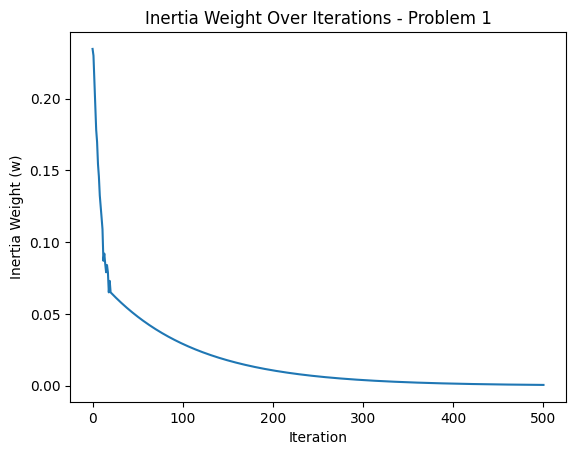

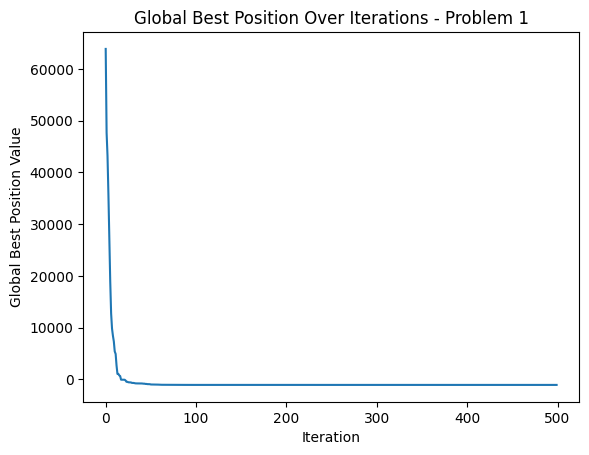




Problem 2 Best Cost: [-701.37550374 -701.40597678 -701.42022958 -701.4427858  -701.46186006
 -701.49637566 -701.54455773 -701.57005796 -701.57400842 -701.58148616
 -701.60331991 -701.62531813 -701.62531813 -701.62850134 -701.64501091
 -701.67483624 -701.67483624 -701.67483624 -701.67587245 -701.69149438
 -701.70406836 -701.70866073 -701.71129241 -701.74830681 -701.75438175
 -701.75438175 -701.75438175 -701.76962124 -701.76962124 -701.77458111
 -701.77590236 -701.77590236 -701.78281876 -701.78281876 -701.79561125
 -701.80388367 -701.81010107 -701.81121886 -701.82046983 -701.82046983
 -701.82139817 -701.82139817 -701.82139817 -701.82469704 -701.83181891
 -701.83181891 -701.83181891 -701.83752744 -701.84125856 -701.86326011
 -701.86326011 -701.86599138 -701.86599138 -701.86599138 -701.86599138
 -701.86599138 -701.87049427 -701.87613686 -701.87613686 -701.87632172
 -701.88283745 -701.88283745 -701.88653336 -701.88653336 -701.8871997
 -701.8871997  -701.89834395 -701.89834395 -701.909354

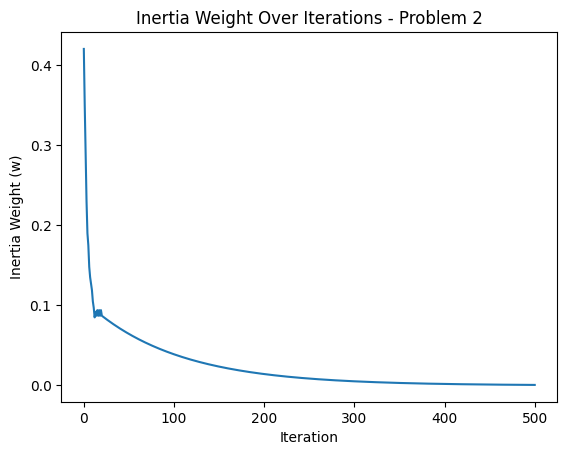

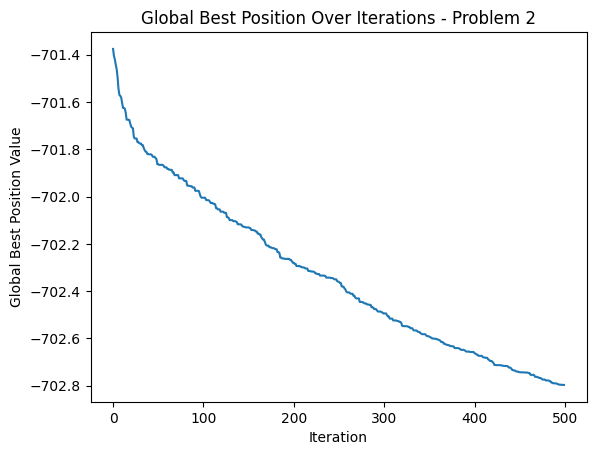




Problem 3 Best Cost: [ 3.63199602e+10  2.75527977e+10  2.35887308e+10  2.10231691e+10
  1.54965017e+10  1.04086385e+10  6.88753999e+09  6.87653833e+09
  5.76734663e+09  4.95343154e+09  4.95343154e+09  4.46331026e+09
  3.28263320e+09  2.03025095e+09  1.93465509e+09  1.78766970e+09
  1.59210146e+09  1.45641197e+09  1.45641197e+09  1.21892190e+09
  1.14855831e+09  1.14855831e+09  1.14855831e+09  1.05487552e+09
  8.74866911e+08  8.08940692e+08  8.08940692e+08  6.98580921e+08
  6.98580921e+08  6.82825312e+08  6.08626466e+08  6.08626466e+08
  5.30891471e+08  5.30891471e+08  4.94792037e+08  4.20676520e+08
  2.37039869e+08  2.37039869e+08  2.16574873e+08  2.16574873e+08
  2.16574873e+08  1.78241775e+08  1.78241775e+08  1.60972400e+08
  1.28203290e+08  1.12188708e+08  1.11479312e+08  1.02624438e+08
  8.56610083e+07  8.56610083e+07  8.56610083e+07  7.87463985e+07
  7.83113201e+07  7.16648090e+07  7.16648090e+07  6.98158512e+07
  5.92081186e+07  5.92081186e+07  5.92081186e+07  5.81781834e+07
 

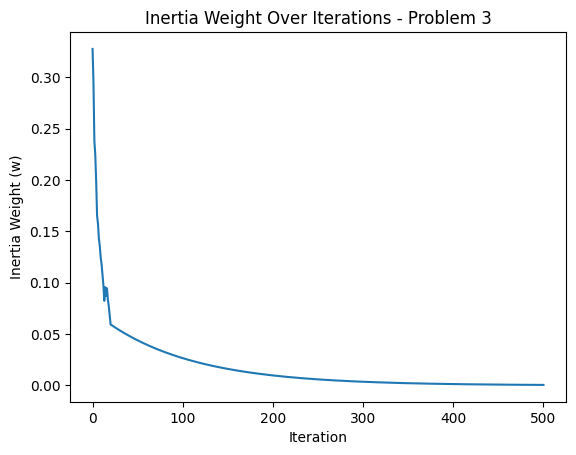

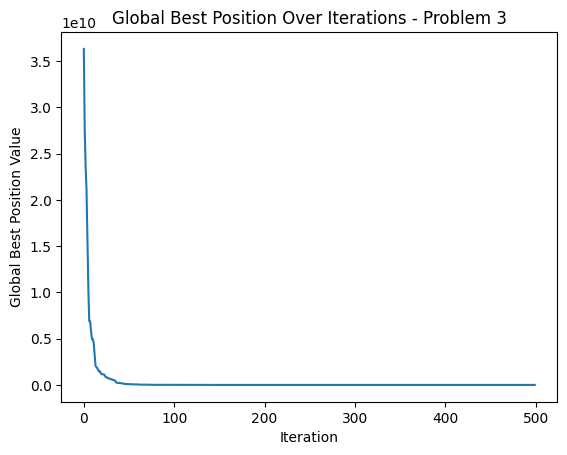




Problem 4 Best Cost: [ 3.22018432e+05  2.15011494e+05  1.81617168e+05  1.36035623e+05
  1.21491409e+05  9.69101057e+04  7.95658855e+04  7.01699425e+04
  5.13758560e+04  4.20845694e+04  2.88391226e+04  2.68947553e+04
  1.77846559e+04  1.54375185e+04  1.54375185e+04  1.40354965e+04
  1.20368096e+04  1.08244939e+04  9.18193560e+03  8.39847133e+03
  8.21590525e+03  7.18854103e+03  5.04034000e+03  3.58661313e+03
  3.50649307e+03  3.50649307e+03  3.16987589e+03  2.75393811e+03
  2.60200114e+03  1.69053328e+03  1.69053328e+03  1.69053328e+03
  1.69053328e+03  1.34362695e+03  1.34362695e+03  1.34362695e+03
  1.14063479e+03  1.13315389e+03  1.13315389e+03  1.11615081e+03
  9.49658490e+02  9.49658490e+02  9.11255515e+02  8.77859493e+02
  8.61610686e+02  7.64125659e+02  7.64125659e+02  5.13699723e+02
  4.01781439e+02  4.01781439e+02  4.01781439e+02  4.01781439e+02
  2.33157585e+02  2.33157585e+02  2.33157585e+02  2.28648017e+02
  1.41387217e+02  1.39593529e+02  1.39593529e+02  8.62781381e+01
 

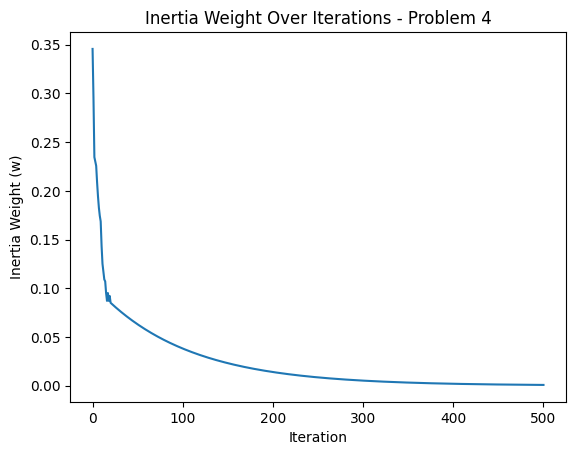

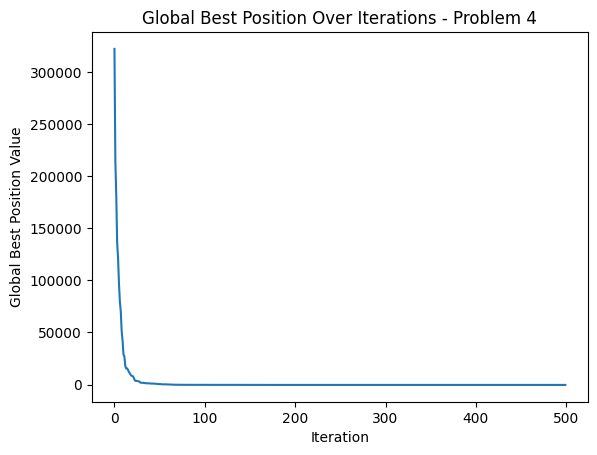




Problem 5 Best Cost: [-334.22075623 -334.26386326 -334.29857877 -334.34860231 -334.43042692
 -334.46966754 -334.49468049 -334.5052841  -334.5052841  -334.62364762
 -334.62364762 -334.62364762 -334.6459625  -334.67118212 -334.67769268
 -334.68000542 -334.71954718 -334.73060033 -334.7654396  -334.7654396
 -334.79080484 -334.82573095 -334.82573095 -334.82573095 -334.82573095
 -334.82573095 -334.82573095 -334.85642021 -334.87145202 -334.87145202
 -334.88030909 -334.88030909 -334.91493879 -334.91828628 -334.93003598
 -334.93003598 -334.93241569 -334.96018495 -334.96018495 -334.96018495
 -334.9770072  -334.99002211 -334.99554805 -335.01769695 -335.01769695
 -335.03679591 -335.03679591 -335.03679591 -335.03679591 -335.04210051
 -335.09862327 -335.09862327 -335.09862327 -335.10513228 -335.10513228
 -335.14568188 -335.14568188 -335.14568188 -335.14568188 -335.16459158
 -335.18616793 -335.18616793 -335.18616793 -335.18616793 -335.18616793
 -335.1936598  -335.20661083 -335.20817051 -335.218395

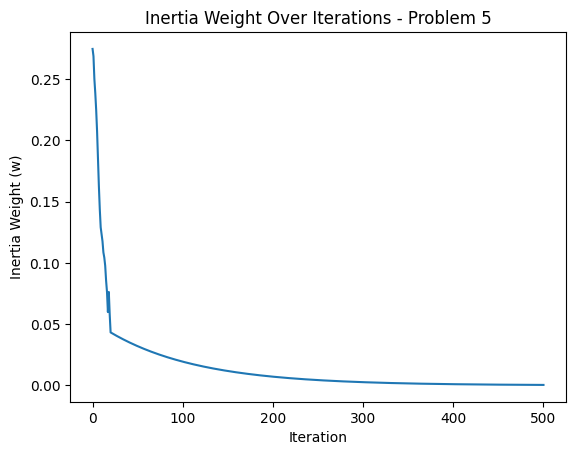

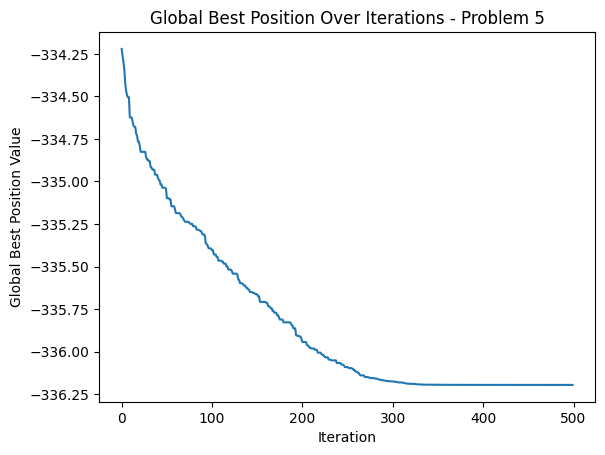




Problem 6 Best Cost: [-183.52152995 -183.58880949 -183.6259011  -183.65182289 -183.71078022
 -183.81614354 -183.87879847 -183.89314375 -183.89314375 -183.92620491
 -183.97994633 -183.97994633 -183.99338065 -184.01245234 -184.01245234
 -184.02088143 -184.02088143 -184.02396266 -184.02396266 -184.03905998
 -184.04529241 -184.06545679 -184.10021343 -184.10021343 -184.10021343
 -184.10749744 -184.11222112 -184.11222112 -184.11810583 -184.12219026
 -184.15240947 -184.15240947 -184.15240947 -184.15702932 -184.15702932
 -184.17012043 -184.17012043 -184.17012043 -184.17012043 -184.17315569
 -184.17353471 -184.22079432 -184.22079432 -184.22079432 -184.22901962
 -184.24013325 -184.25725931 -184.27541646 -184.2929162  -184.2929162
 -184.2929162  -184.30605365 -184.31240214 -184.31815301 -184.3354192
 -184.33620952 -184.33620952 -184.33620952 -184.33987182 -184.35706223
 -184.35706223 -184.39161622 -184.39161622 -184.4018251  -184.41559639
 -184.41559639 -184.41559639 -184.41559639 -184.4317467

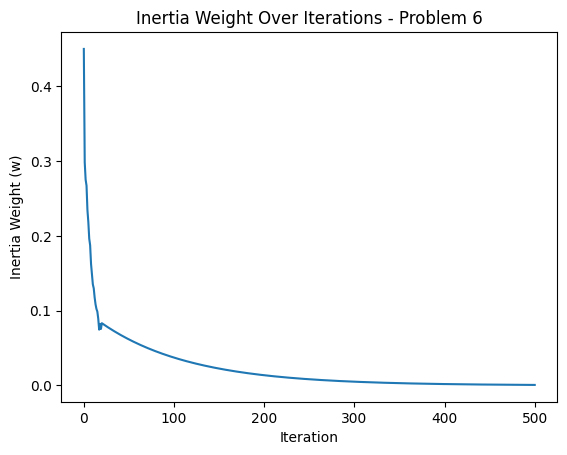

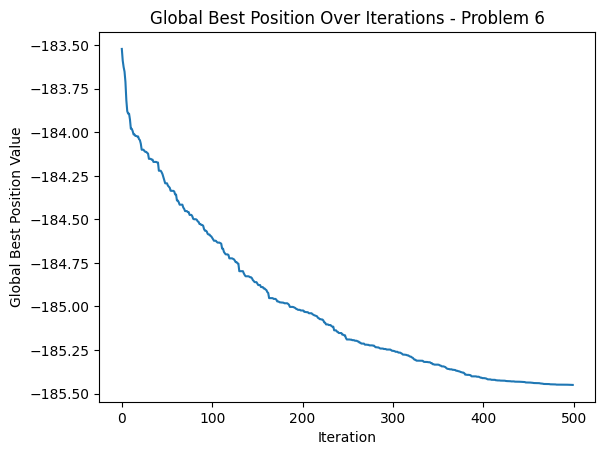




Problem 7 Best Cost: [ 7.24943368e+04  4.95620270e+04  3.49613158e+04  3.49613158e+04
  3.49613158e+04  3.12720255e+04  2.86511230e+04  2.22960972e+04
  1.76971797e+04  1.76971797e+04  1.29230832e+04  1.24523462e+04
  1.16440714e+04  1.13821569e+04  1.04442727e+04  8.76739155e+03
  8.43955813e+03  8.43955813e+03  8.08344692e+03  6.97610371e+03
  3.80709142e+03  3.57489674e+03  2.83487212e+03  2.83487212e+03
  2.83487212e+03  2.55394490e+03  2.55394490e+03  1.70661201e+03
  1.70661201e+03  1.16922065e+03  1.15696415e+03  8.73099286e+02
  4.04825794e+02  4.04825794e+02 -6.97209285e+01 -6.97209285e+01
 -6.97209285e+01 -1.69628272e+02 -1.72327385e+02 -1.72327385e+02
 -1.72327385e+02 -1.79853631e+02 -2.50563495e+02 -2.50563495e+02
 -2.50563495e+02 -3.15579543e+02 -3.15579543e+02 -3.25267957e+02
 -3.25267957e+02 -3.25267957e+02 -3.25267957e+02 -3.51548298e+02
 -3.84777644e+02 -4.72767790e+02 -4.79875003e+02 -4.79875003e+02
 -4.79875003e+02 -4.79875003e+02 -4.79875003e+02 -5.13072056e+02
 

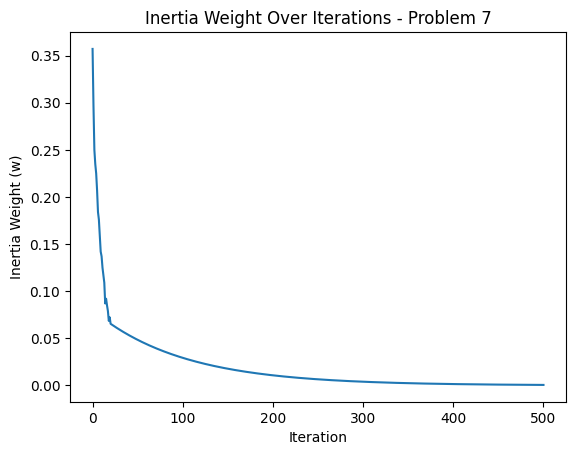

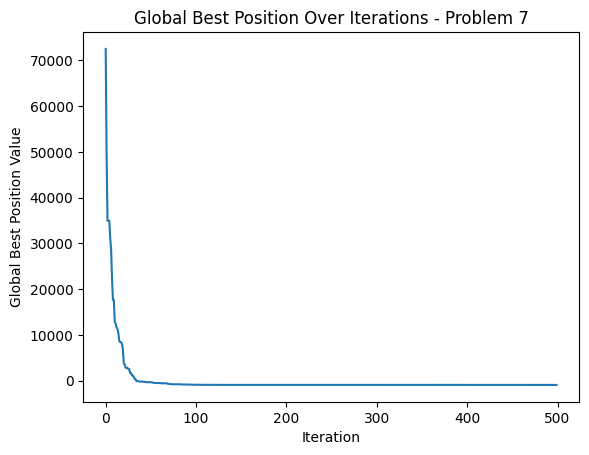




Problem 8 Best Cost: [ 5.83861851e+04  5.61552798e+04  3.78170237e+04  2.73261904e+04
  2.65645380e+04  2.65645380e+04  2.30822360e+04  2.11995582e+04
  2.11995582e+04  2.10671351e+04  2.10671351e+04  2.10671351e+04
  2.10671351e+04  2.10671351e+04  2.10671351e+04  2.09403052e+04
  1.78551612e+04  1.73697744e+04  1.43106118e+04  1.43106118e+04
  1.43106118e+04  1.43106118e+04  1.41609715e+04  1.28079899e+04
  1.28079899e+04  1.28079899e+04  1.18311310e+04  1.18311310e+04
  1.18311310e+04  1.18311310e+04  1.18311310e+04  1.18311310e+04
  1.18311310e+04  9.57755942e+03  9.57755942e+03  9.57755942e+03
  9.50721795e+03  6.70885039e+03  6.70885039e+03  6.70885039e+03
  6.70885039e+03  6.70885039e+03  6.70885039e+03  6.70885039e+03
  5.67544871e+03  5.67544871e+03  5.52943156e+03  5.30956279e+03
  5.30956279e+03  4.77486638e+03  4.77486638e+03  4.61414593e+03
  3.05536894e+03  2.75753129e+03  2.75753129e+03  2.75753129e+03
  2.64319137e+03  2.64319137e+03  1.52533950e+03  1.52533950e+03
 

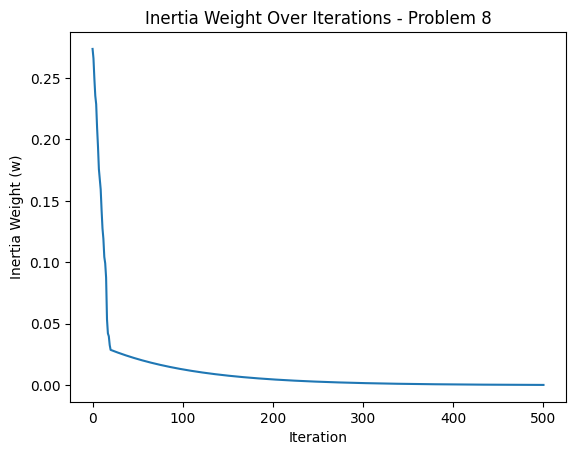

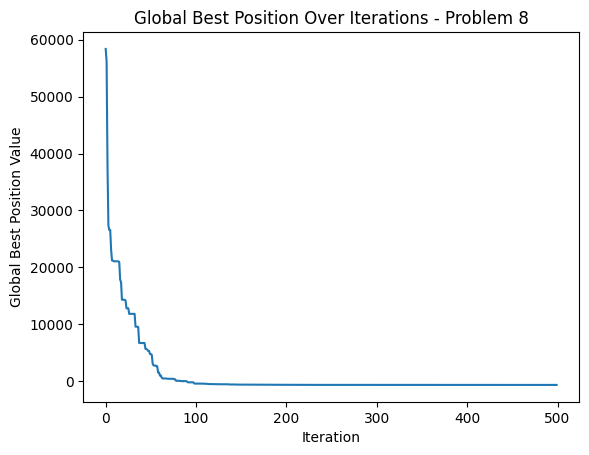




Problem 9 Best Cost: [2.47996091e+05 1.47265527e+05 1.39005845e+05 1.37548164e+05
 1.37548164e+05 7.11967834e+04 6.58543011e+04 6.09082382e+04
 4.85304650e+04 4.85304650e+04 4.85304650e+04 1.01135537e+04
 1.01135537e+04 1.01135537e+04 1.01135537e+04 1.01135537e+04
 1.01135537e+04 1.01135537e+04 1.01135537e+04 8.81178868e+03
 8.81178868e+03 8.81178868e+03 8.81178868e+03 8.81178868e+03
 8.81178868e+03 8.81178868e+03 7.85865926e+03 7.85865926e+03
 7.85865926e+03 7.85865926e+03 7.85865926e+03 4.18730909e+03
 4.18730909e+03 4.18730909e+03 4.18730909e+03 4.18730909e+03
 4.18730909e+03 4.18730909e+03 4.18730909e+03 3.55765862e+03
 3.55765862e+03 3.55765862e+03 3.55765862e+03 3.55765862e+03
 3.55765862e+03 3.55765862e+03 2.93787983e+03 2.93787983e+03
 2.93787983e+03 2.70514257e+03 2.70514257e+03 1.99747745e+03
 1.99747745e+03 1.96900020e+03 1.96900020e+03 1.96900020e+03
 1.96900020e+03 1.96900020e+03 1.96900020e+03 1.96900020e+03
 1.96900020e+03 1.96900020e+03 1.72703554e+03 1.72703554e+03


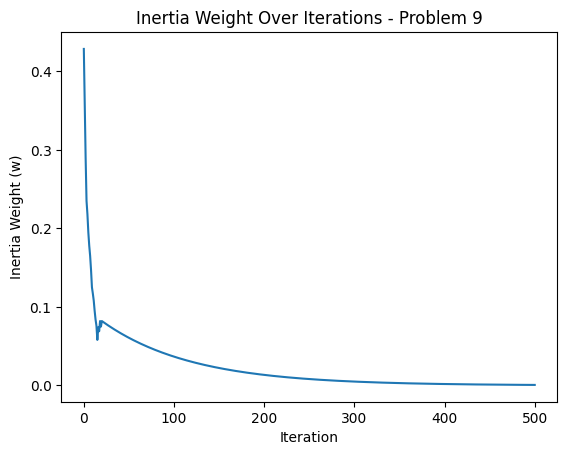

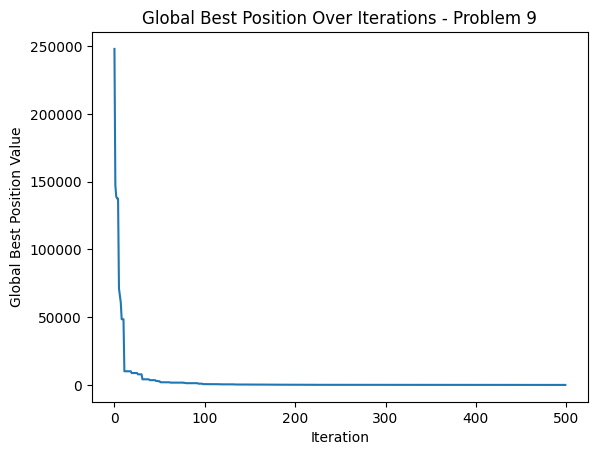




Problem 10 Best Cost: [57043.33495331 28516.70146062 27162.79279269 24012.88789859
 19324.3397088  17850.41495523 14399.53985257 12853.52539474
 12853.52539474 12853.52539474 12511.59693361 12511.59693361
 10791.08009806 10389.13020771 10389.13020771 10389.13020771
  9612.72168783  9612.72168783  9612.72168783  8732.79838398
  8732.79838398  8430.02926525  6549.63819349  6208.13672501
  5411.89764283  4481.83285843  4481.83285843  4481.83285843
  3455.64481249  3455.64481249  3455.64481249  3455.64481249
  3455.64481249  3455.64481249  3455.64481249  3455.64481249
  2917.54454982  2917.54454982  2917.54454982  2897.84640853
  2321.97857025  2321.97857025  2180.35994096  2180.35994096
  2027.27088046  2027.27088046  2027.27088046  2027.27088046
  2027.27088046  2027.27088046  2004.21526826  2004.21526826
  2004.21526826  1837.71107178  1837.71107178  1837.71107178
  1796.30800845  1796.30800845  1724.39709602  1724.39709602
  1657.15570896  1493.42379534  1384.55148702  1384.55148702

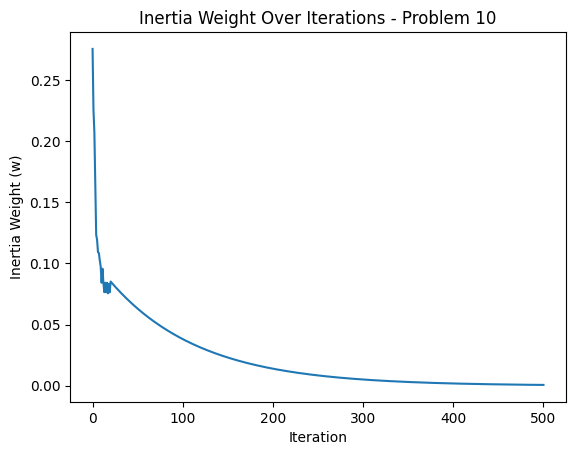

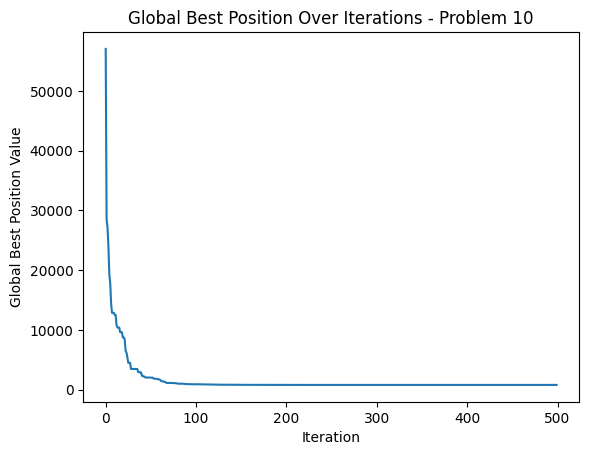




Problem 11 Best Cost: [ 6.48519043e+04  5.92823601e+04  3.63489917e+04  3.57846133e+04
  3.11209034e+04  2.64273581e+04  1.75860504e+04  1.56402754e+04
  1.35594802e+04  1.16127694e+04  1.16127694e+04  1.16127694e+04
  1.04738200e+04  1.03885631e+04  9.27159884e+03  7.39070159e+03
  7.38225170e+03  6.98158442e+03  6.11591651e+03  6.11591651e+03
  6.11591651e+03  6.11591651e+03  5.74442387e+03  4.57353251e+03
  4.57353251e+03  4.21733264e+03  4.21733264e+03  3.49075197e+03
  3.20457674e+03  3.03931451e+03  2.90296655e+03  2.05224091e+03
  2.05224091e+03  1.53219233e+03  1.53219233e+03  1.53219233e+03
  1.53219233e+03  1.30691721e+03  1.30691721e+03  1.30691721e+03
  1.30691721e+03  1.22510042e+03  1.22510042e+03  1.22510042e+03
  1.22510042e+03  1.22510042e+03  1.22510042e+03  1.03391207e+03
  1.03391207e+03  9.90849097e+02  8.69426953e+02  6.52014134e+02
  6.52014134e+02  6.52014134e+02  6.52014134e+02  6.52014134e+02
  6.52014134e+02  6.52014134e+02  6.31314223e+02  6.31314223e+02


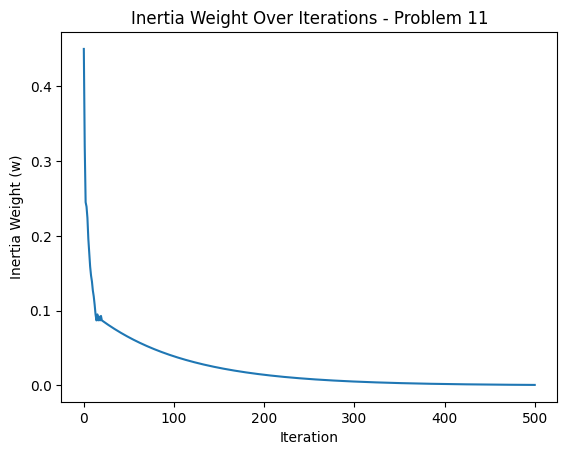

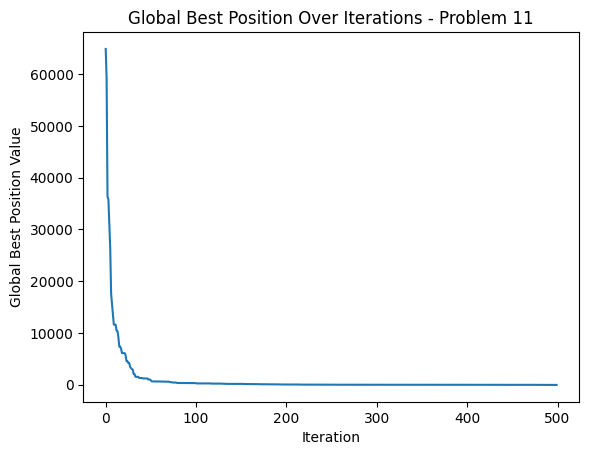




Problem 12 Best Cost: [72432.06041082 53948.21492548 42320.63353864 28538.26042622
 28538.26042622 21870.87327305 21870.87327305 21870.87327305
 21533.15684632 20219.70949953 19751.18118325 15997.52157848
 15997.52157848 15997.52157848 15997.52157848 15997.52157848
 11810.2074983  11666.44100861 11666.44100861  9462.23515942
  8641.32611857  8641.32611857  8641.32611857  8641.32611857
  8641.32611857  8641.32611857  8641.32611857  8641.32611857
  8641.32611857  7384.71139432  7384.71139432  7384.71139432
  7034.44525782  6627.81627279  6603.48735489  6603.48735489
  6603.48735489  6360.60349239  6360.60349239  6360.60349239
  5598.22032875  5598.22032875  5598.22032875  5483.44850471
  5483.44850471  5343.69383347  5343.69383347  5343.69383347
  4030.4010239   4030.4010239   4030.4010239   4030.4010239
  4030.4010239   4030.4010239   4030.4010239   4030.4010239
  4030.4010239   4030.4010239   4030.4010239   4030.4010239
  4030.4010239   4030.4010239   4030.4010239   4030.4010239
  4

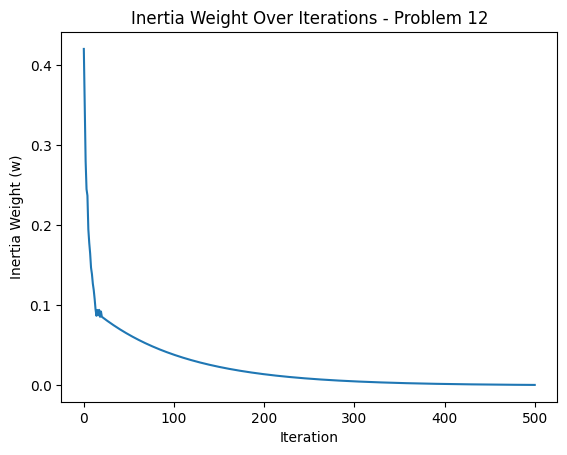

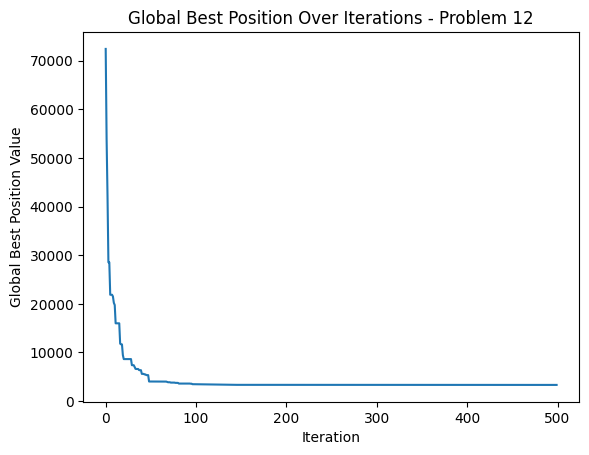




Problem 13 Best Cost: [224926.99205999 131472.28287612 131387.31259109 131387.31259109
  78345.39659046  78345.39659046  78345.39659046  63960.85646013
  63960.85646013  63960.85646013  63960.85646013  63960.85646013
  63960.85646013  63960.85646013  63960.85646013  63960.85646013
  63960.85646013  48161.51707389  48161.51707389  48161.51707389
  48161.51707389  48161.51707389  48161.51707389  48161.51707389
  48161.51707389  48161.51707389  48161.51707389  48161.51707389
  48161.51707389  48161.51707389  48161.51707389  48161.51707389
  48161.51707389  48161.51707389  48161.51707389  48161.51707389
  48161.51707389  48161.51707389  48161.51707389  48161.51707389
  48161.51707389  48161.51707389  48161.51707389  48161.51707389
  48161.51707389  48161.51707389  48161.51707389  48161.51707389
  48161.51707389  48161.51707389  48161.51707389  48161.51707389
  48161.51707389  48161.51707389  48161.51707389  48161.51707389
  48161.51707389  48161.51707389  45395.46329455  45395.46329455


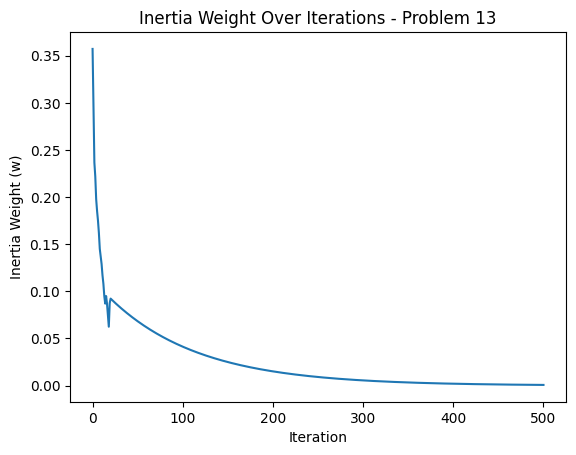

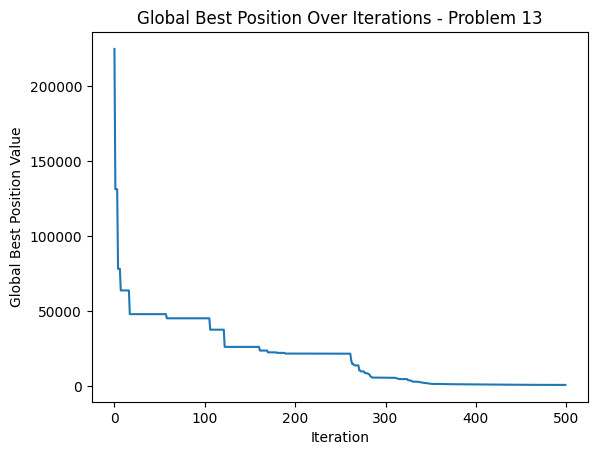




Problem 14 Best Cost: [34829.2174768  30968.94359704 27844.16662033 25382.12237714
 24829.28692313 24147.43417081 20924.07795539 20924.07795539
 20924.07795539 19197.12813964 19197.12813964 19197.12813964
 19197.12813964 19197.12813964 19197.12813964 19197.12813964
 19197.12813964 19197.12813964 19197.12813964 19197.12813964
 19197.12813964 19197.12813964 19197.12813964 19197.12813964
 19197.12813964 19197.12813964 19197.12813964 19197.12813964
 18048.09210685 17911.56466462 17911.56466462 17911.56466462
 17911.56466462 17911.56466462 17869.47984622 17869.47984622
 17869.47984622 17869.47984622 17869.47984622 17869.47984622
 17869.47984622 17869.47984622 17869.47984622 17869.47984622
 17533.89175231 17533.89175231 17533.89175231 17420.95605011
 17420.95605011 17420.95605011 17420.95605011 17420.95605011
 17420.95605011 17420.95605011 17420.95605011 17420.95605011
 17270.17900121 17127.37848066 16784.33043022 16674.21185863
 16674.21185863 16550.02970973 16550.02970973 16550.02970973

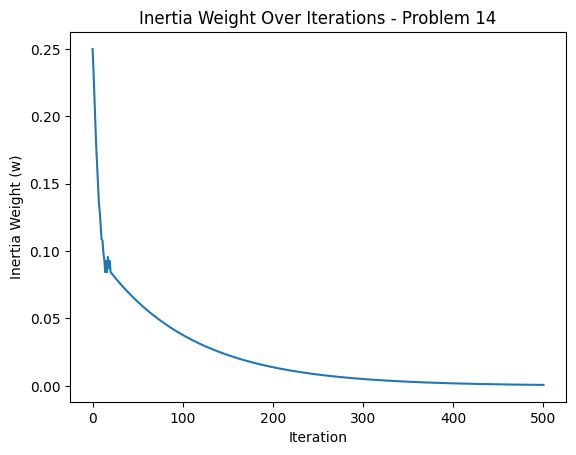

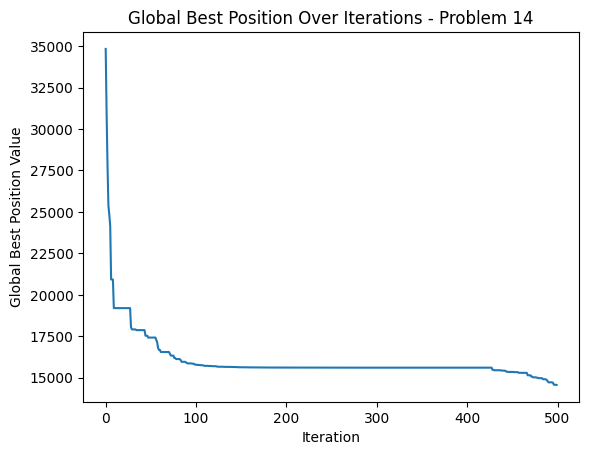




Problem 15 Best Cost: [-224.62628155 -224.62628155 -224.98135177 -224.98135177 -225.43331987
 -225.43331987 -225.43331987 -225.45141538 -225.45141538 -225.45141538
 -225.45141538 -225.78999045 -225.78999045 -226.21502562 -226.21502562
 -226.21502562 -226.21502562 -226.21502562 -226.21502562 -226.21502562
 -226.55139706 -226.55139706 -226.55139706 -226.55139706 -226.55139706
 -226.55139706 -226.55139706 -226.55139706 -226.55139706 -226.55139706
 -226.98821625 -226.98821625 -227.08320148 -227.08320148 -227.08320148
 -227.19253707 -227.19253707 -227.19253707 -227.60529671 -227.60529671
 -227.60529671 -227.60529671 -227.60529671 -227.60529671 -227.69941037
 -227.69941037 -227.69941037 -227.69941037 -227.69941037 -227.79000844
 -227.79000844 -227.79000844 -227.79236263 -227.79236263 -228.15690522
 -228.15690522 -228.15690522 -228.15690522 -228.15690522 -228.15690522
 -228.15690522 -228.15690522 -228.15690522 -228.15690522 -228.15690522
 -228.15690522 -228.15690522 -228.15690522 -228.1569

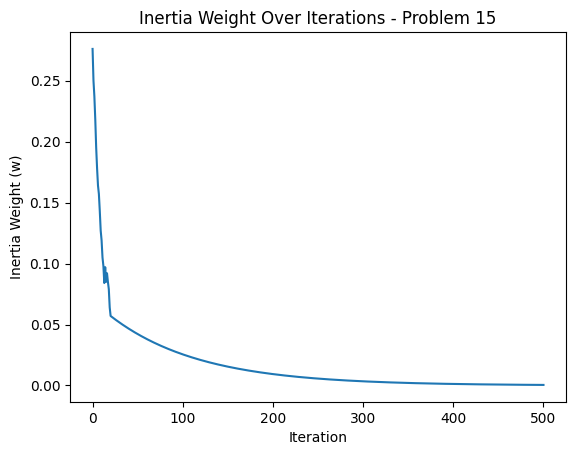

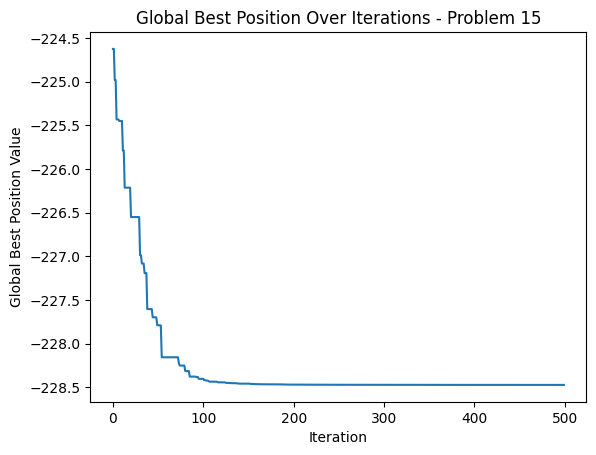




Problem 16 Best Cost: [70727.87729815 40094.28699806 23357.59360645 20486.44154879
 16717.6683814  10288.96658032  5313.93789354  3895.13750205
  3693.21156675  1032.75932081  -328.82102064 -1700.25862744
 -1700.25862744 -1700.25862744 -1984.72772526 -2105.57038087
 -2849.86041405 -3377.47273757 -3377.47273757 -3377.47273757
 -3404.78010201 -3603.77866987 -3676.59608804 -3802.79176141
 -3802.79176141 -3814.8563664  -3960.2399754  -3972.08620663
 -3972.08620663 -4016.21854048 -4066.29075049 -4097.14857286
 -4097.14857286 -4097.14857286 -4097.14857286 -4155.37302676
 -4155.37302676 -4159.90847519 -4174.98190362 -4174.98190362
 -4187.21235092 -4196.75010739 -4199.56224381 -4223.71780597
 -4237.91283402 -4237.91283402 -4237.91283402 -4240.9924703
 -4240.9924703  -4248.45366237 -4250.17066055 -4254.54187505
 -4266.61326383 -4266.61326383 -4266.61326383 -4272.03898584
 -4279.66495459 -4281.12038857 -4288.36422152 -4288.36422152
 -4288.36422152 -4288.36422152 -4288.36422152 -4288.36422152


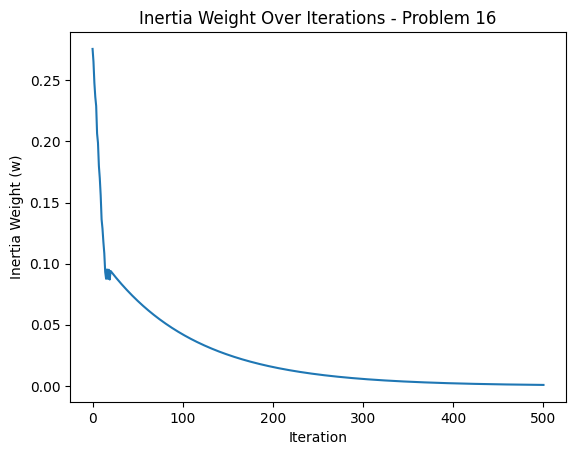

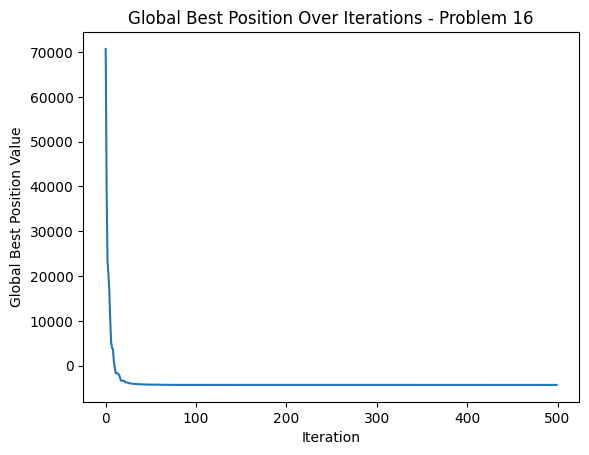




Problem 17 Best Cost: [ 2.86873805e+06  2.37514415e+06  1.92407813e+06  1.57810270e+06
  1.13045593e+06  9.91144208e+05  9.51041765e+05  8.46227617e+05
  6.30813398e+05  5.02220546e+05  4.20354337e+05  3.74947959e+05
  2.86073607e+05  2.64577858e+05  2.22812777e+05  1.77101254e+05
  1.20581498e+05  9.22803303e+04  7.53475794e+04  7.10411409e+04
  6.76282542e+04  6.76282542e+04  5.77492409e+04  5.53854596e+04
  4.23868432e+04  3.49212270e+04  3.35156348e+04  3.35156348e+04
  3.28483948e+04  3.24901283e+04  2.91241818e+04  2.91241818e+04
  2.86690495e+04  2.86509164e+04  2.59437856e+04  2.24630305e+04
  2.10264361e+04  2.10264361e+04  1.83323756e+04  1.83323756e+04
  1.83323756e+04  1.83323756e+04  1.83323756e+04  1.73439657e+04
  1.73439657e+04  1.51479888e+04  1.51479888e+04  1.18304048e+04
  1.18304048e+04  9.83513459e+03  9.43050582e+03  9.43050582e+03
  9.43050582e+03  6.73756096e+03  6.73756096e+03  6.73756096e+03
  6.73756096e+03  5.02289064e+03  5.02289064e+03  5.02289064e+03


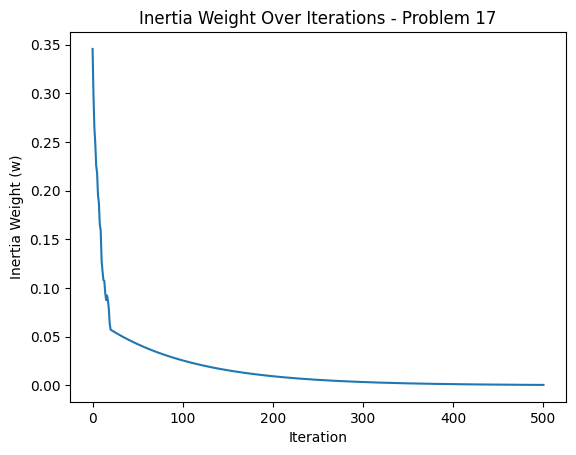

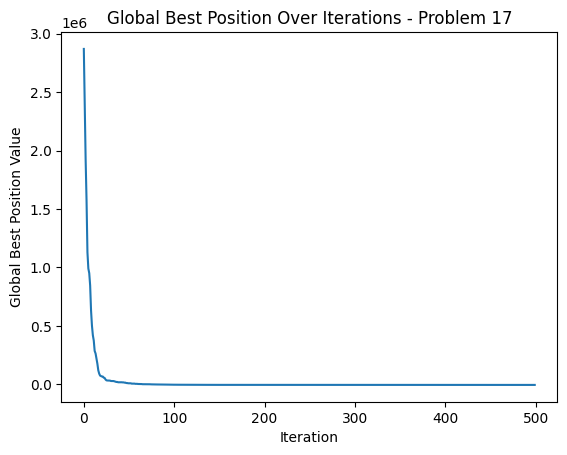




Problem 18 Best Cost: [38526.74676201 38526.74676201 33846.05728671 33846.05728671
 30976.85730427 26960.95288614 19770.15084615 18657.34347382
 18657.34347382 18657.34347382 17082.23647422 13176.94838703
 10580.88419723  8740.3559372   6180.77004705  5195.95821842
  2335.53257085  2335.53257085  2335.53257085  2335.53257085
  2335.53257085  2335.53257085  2335.53257085  2335.53257085
  1938.58506352  1938.58506352  1938.58506352  1938.58506352
  1422.79564053  1422.79564053  1389.66000906  1389.66000906
  1389.66000906  1309.58749308  1309.58749308  1192.38350257
  1192.38350257  1192.38350257  1168.82623689  1168.82623689
   619.07712054   619.07712054   619.07712054   619.07712054
   619.07712054   619.07712054   619.07712054   619.07712054
   619.07712054   619.07712054   619.07712054   619.07712054
   619.07712054   619.07712054   619.07712054   619.07712054
   619.07712054   619.07712054   619.07712054   619.07712054
   619.07712054   505.51899134   505.51899134   505.51899134

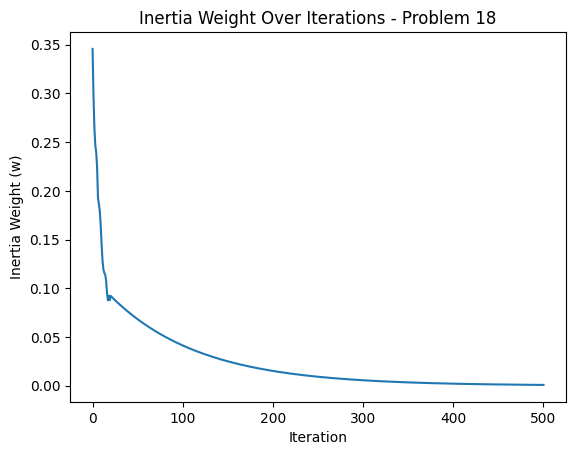

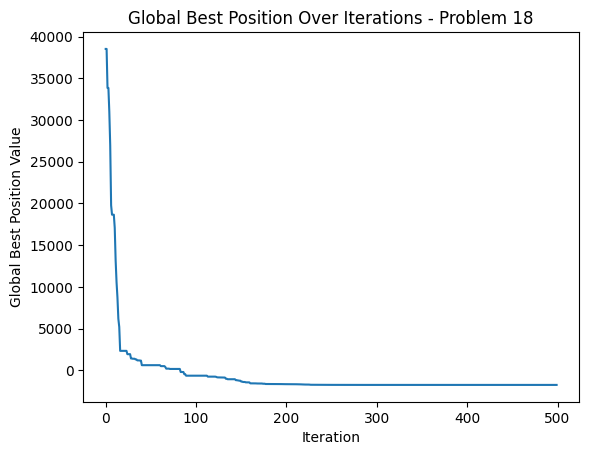




Problem 19 Best Cost: [75348.94324772 44585.33050223 44585.33050223 40150.71609828
 40150.71609828 40150.71609828 40150.71609828 33779.09499723
 33779.09499723 29216.70044277 29216.70044277 21339.64479837
 21339.64479837 21339.64479837 21339.64479837 21339.64479837
 21339.64479837 21339.64479837 21339.64479837 21339.64479837
 21339.64479837 21339.64479837 21339.64479837 21339.64479837
 21339.64479837 21339.64479837 21339.64479837 21339.64479837
 21339.64479837 21339.64479837 21339.64479837 21339.64479837
 21339.64479837 21339.64479837 21339.64479837 21339.64479837
 21339.64479837 21339.64479837 21339.64479837 21339.64479837
 21339.64479837 21339.64479837 21339.64479837 21339.64479837
 21339.64479837 21339.64479837 21339.64479837 21339.64479837
 21339.64479837 21339.64479837 21339.64479837 21339.64479837
 21339.64479837 20170.58888753 20170.58888753 20170.58888753
 20170.58888753 18579.43880474 18579.43880474 18579.43880474
 18579.43880474 18579.43880474 18579.43880474 18579.43880474

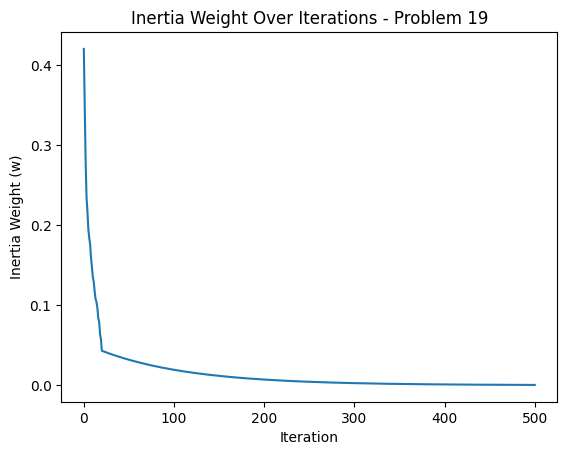

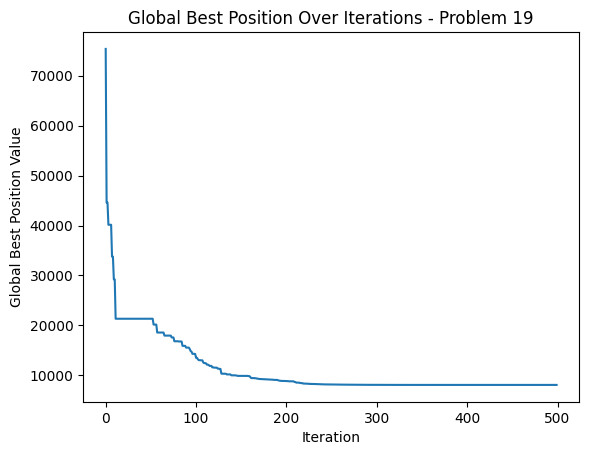




Problem 20 Best Cost: [-83.06881742 -83.72050158 -85.2319517  -85.2319517  -85.2319517
 -85.2319517  -85.69262715 -85.69262715 -85.83411617 -85.83411617
 -85.83558193 -85.84195987 -85.93974937 -86.40985726 -87.79803019
 -87.9073886  -87.9073886  -88.00664573 -88.79493478 -88.79493478
 -88.79493478 -89.20973507 -89.20973507 -89.28164061 -89.48529641
 -89.64947168 -89.70510781 -89.70510781 -89.81281561 -90.21140156
 -90.21140156 -90.27890552 -90.27890552 -90.47888914 -90.79515396
 -90.79515396 -90.79515396 -90.79515396 -90.79515396 -90.79515396
 -90.79515396 -90.81713895 -90.85191771 -90.85191771 -90.85191771
 -91.1055252  -91.13002568 -91.13002568 -91.13002568 -91.13002568
 -91.13002568 -91.13002568 -91.15508273 -91.34741201 -91.34741201
 -91.34741201 -91.34741201 -91.34741201 -91.34741201 -91.34741201
 -91.34741201 -91.34741201 -91.34741201 -91.34741201 -91.34741201
 -91.34741201 -91.34741201 -91.34741201 -91.34741201 -91.34741201
 -91.35451398 -91.35451398 -91.36788398 -91.36788398

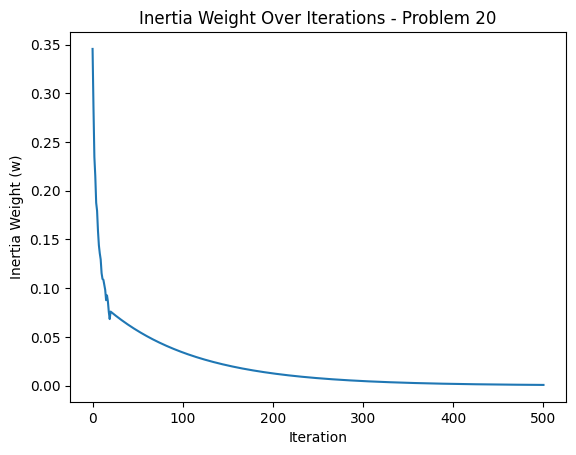

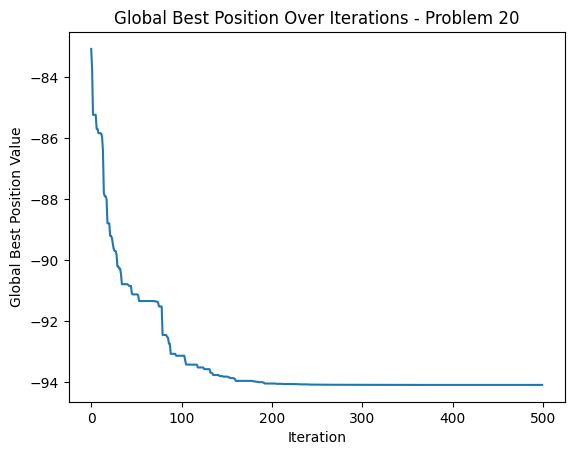




Problem 21 Best Cost: [135.66878819  88.63423108  51.74387543  28.42118747  15.09097038
  13.9340302    5.05729277  -0.44257728  -2.44090048  -3.04210664
 -11.68600188 -12.76767948 -12.76767948 -13.72496643 -20.9350498
 -20.9350498  -20.9350498  -21.2821468  -21.2821468  -21.2821468
 -22.54753089 -22.54753089 -22.54753089 -23.84933643 -24.42074658
 -25.35356674 -25.35356674 -25.35356674 -25.35356674 -27.55168742
 -29.02137888 -29.02137888 -29.02137888 -29.64704924 -30.46473898
 -30.46473898 -30.46473898 -30.46473898 -31.69678322 -31.69678322
 -32.58869182 -33.08794432 -33.08794432 -33.08794432 -33.20241137
 -34.16127336 -35.12239154 -35.12239154 -35.12239154 -35.12239154
 -35.12239154 -35.12239154 -35.12239154 -35.12239154 -35.12239154
 -36.00119744 -36.00119744 -36.10560046 -36.87510092 -36.87510092
 -36.87510092 -36.87510092 -36.87510092 -36.87510092 -37.23642057
 -37.23642057 -37.27598362 -37.52671172 -37.52671172 -37.52671172
 -37.60629986 -37.62469505 -37.62469505 -37.85249692 

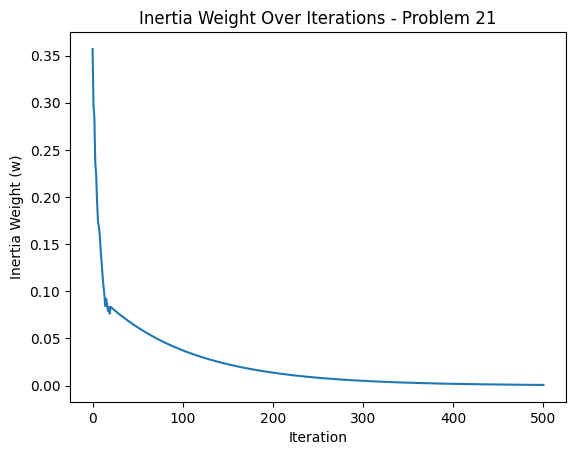

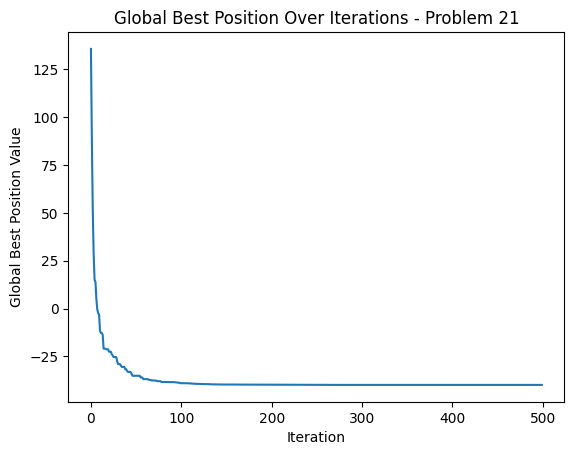




Problem 22 Best Cost: [288157.51283365 210703.07154631 207244.74921156 207244.74921156
 184280.52697263 181025.71485142 181025.71485142 181025.71485142
 181025.71485142 181025.71485142 158162.23589749 158162.23589749
 158162.23589749 158162.23589749 158162.23589749 158162.23589749
 152140.46072889 152140.46072889 129393.2447825  129393.2447825
 129393.2447825  129393.2447825  129393.2447825  129393.2447825
 129393.2447825  129393.2447825  129393.2447825  129393.2447825
 129393.2447825  129393.2447825  129393.2447825  129393.2447825
 129393.2447825  126899.01080832 126899.01080832 126899.01080832
 126899.01080832 126899.01080832 126899.01080832 117912.6881131
 117912.6881131  106424.37574354 106424.37574354 106424.37574354
 106424.37574354 106424.37574354 106424.37574354 100450.6480943
 100450.6480943  100450.6480943  100450.6480943  100450.6480943
  99643.09904386  99345.45805885  98452.43438438  97637.04115812
  97637.04115812  96429.62848471  96429.62848471  96429.62848471
  96429

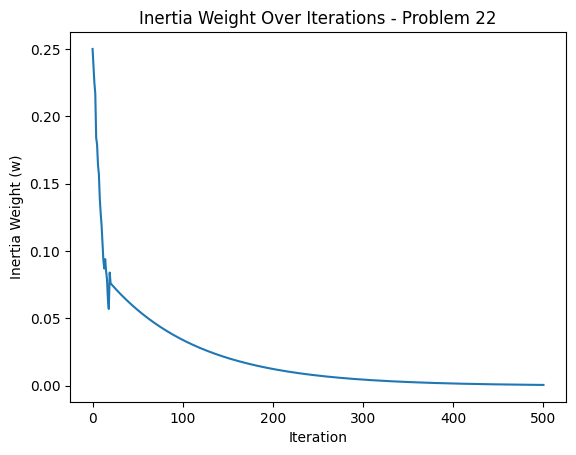

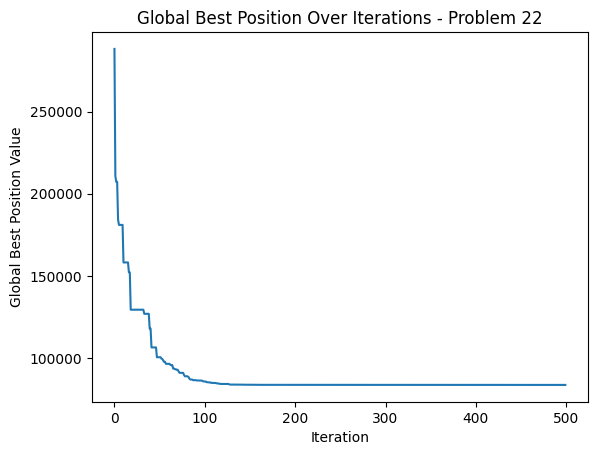




Problem 23 Best Cost: [-21.61088573 -24.67739982 -30.95348874 -31.36711015 -37.73859129
 -40.82729241 -40.82729241 -40.82729241 -40.82729241 -40.82729241
 -40.82729241 -40.82729241 -40.82729241 -40.82729241 -40.82729241
 -40.82729241 -40.82729241 -42.58910699 -42.58910699 -45.05792549
 -45.56759149 -45.56759149 -45.56759149 -45.56759149 -45.56759149
 -45.56759149 -45.56759149 -45.56759149 -45.56759149 -45.56759149
 -45.56759149 -45.56759149 -45.56759149 -45.56759149 -45.56759149
 -45.56759149 -45.56759149 -45.56759149 -45.56759149 -45.56759149
 -45.56759149 -45.56759149 -45.56759149 -51.70353215 -51.70353215
 -51.70353215 -52.79668064 -52.79668064 -52.79668064 -52.79668064
 -52.79668064 -52.79668064 -52.79668064 -52.79668064 -52.79668064
 -52.79668064 -52.79668064 -52.79668064 -52.79668064 -52.79668064
 -52.79668064 -52.79668064 -52.79668064 -53.69956533 -53.69956533
 -53.69956533 -53.69956533 -53.69956533 -53.69956533 -53.69956533
 -53.69956533 -53.69956533 -53.69956533 -53.6995653

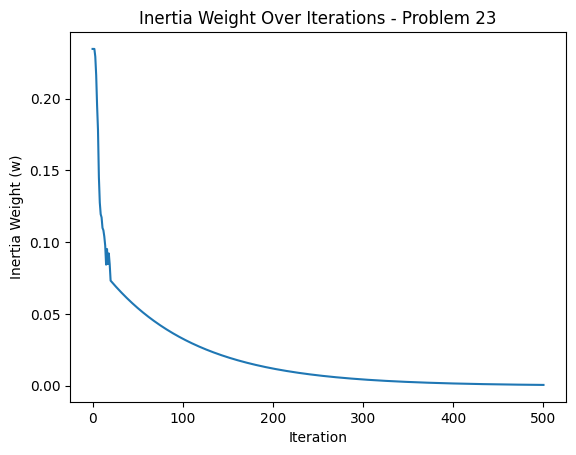

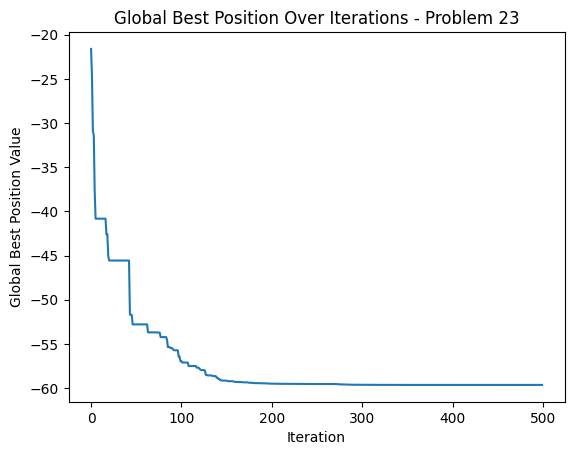




Problem 24 Best Cost: [115.08400328 114.51716826 101.49837421 100.73061875 100.73061875
  97.80694836  97.80694836  97.80694836  95.24830129  95.24830129
  87.81341523  87.81341523  79.59095365  79.59095365  79.59095365
  79.59095365  79.59095365  79.59095365  79.59095365  79.59095365
  79.59095365  79.59095365  78.65728113  78.65728113  78.65728113
  78.65728113  77.87732159  77.87732159  77.87732159  77.87732159
  77.87732159  77.87732159  77.87732159  77.87732159  77.87732159
  77.87732159  77.87732159  77.87732159  77.87732159  77.87732159
  77.87732159  77.87732159  77.87732159  77.87732159  77.87732159
  77.87732159  77.87732159  77.87732159  75.60822283  75.60822283
  75.60822283  75.60822283  75.60822283  75.60822283  75.60822283
  75.60822283  75.60822283  75.60822283  75.60822283  75.60822283
  75.60822283  75.60822283  75.60822283  75.60822283  75.60822283
  75.60822283  75.60822283  75.60822283  75.60822283  75.60822283
  75.60822283  75.60822283  75.60822283  73.6798641

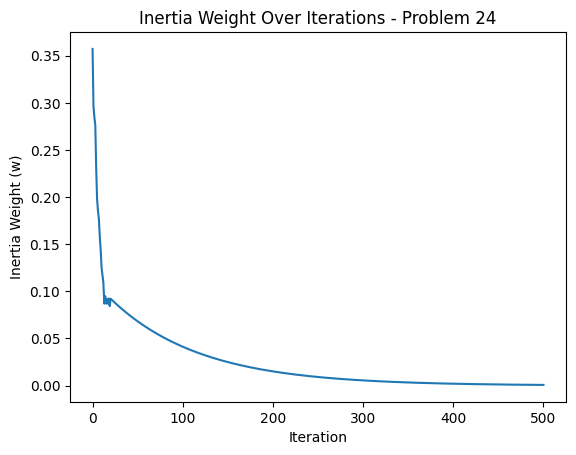

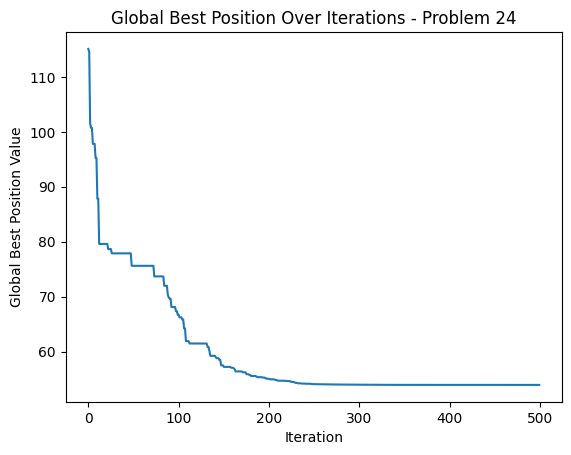

In [21]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]

    print("\n\n\nProblem", curr, "Best Cost:", problem_results['BestCost'])
    print("Problem", curr, "Best Position:", problem_results['BestPosition'])

    plt.plot(problem_results['w_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Inertia Weight (w)')
    plt.title(f'Inertia Weight Over Iterations - Problem {curr}')
    plt.show()

    plt.plot(problem_results['g_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Global Best Position Value')
    plt.title(f'Global Best Position Over Iterations - Problem {curr}')
    plt.show()

In [22]:
print('nice')

nice


In [23]:
print('almost complete')

almost complete


In [24]:
print("Don't disconnect runtime")

Don't disconnect runtime


In [25]:
print('ok')

ok
